In [2]:
import os
import argparse
import numpy as np
import torch
from torch import nn, optim

import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torchvision
from torchvision.utils import save_image, make_grid
from torchvision import datasets, transforms
from time import time

from tqdm import tqdm_notebook as tqdm

def sample_labels(bs, N_CLASSES=10):
    return nn.functional.one_hot(torch.randint(low=0,high=N_CLASSES, size=(bs,)).long(), num_classes=N_CLASSES).float()

# Genetaring `G(z, label)`

In [3]:
from tqdm.notebook import tqdm
import os
import argparse
import numpy as np
import torch
from torch import nn, optim

from torch.utils.data import DataLoader

import torchvision
from torchvision.utils import save_image, make_grid
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

DEVICE = 'cuda:4'

In [252]:
from modules import Autoencoder
args = {'eval_each': 10, 'epochs': 101, 'latent_width': 4, 'lr': 0.0001, 'n_classes': 10, 'depth': 16, 'latent': 2,
        'log_dir': '4DatasetExperiment/MNIST_latent2/', 'width': 32, 'device': 'cuda:3', 'dataset': 'MNIST', 'batch_size': 64,
        'weight_decay': 1e-05, 'gamma': 0.2, 'batch_norm': False, 'colors': 1, 'advdepth': 16,  'lmbda': 0.5}

def ae_from_dict(args, state_dict):
    scales = int(round(np.log2(args['width'] // args['latent_width'])))
    autoencoder = Autoencoder(scales=scales,depth=args['depth'],latent=args['latent'],colors=args['colors'],
                              batch_norm=False).to(DEVICE)
    autoencoder.load_state_dict(torch.load(state_dict))
    
    return autoencoder

autoencoder = ae_from_dict(args, '/root/AutoEncoders/4DatasetExperiment/MNIST_latent2/Autoencoder.torch')
autoencoder.to(DEVICE);

In [253]:
autoencoder = ae_from_dict(args, '/root/AutoEncoders/4DatasetExperiment/MNIST_latent2/Autoencoder.torch')
autoencoder.to(DEVICE);

### `Architechture`

In [4]:
class FCBlock(nn.Module):
    def __init__(self, inp, oup, p_drop=0, bn=False):        
        super(FCBlock, self).__init__()
        self.p_drop = p_drop
        self.linear = nn.Linear(inp, oup)
        self.D = nn.Dropout(p=p_drop)
        
        if bn:
            self.relu = nn.Sequential(nn.BatchNorm1d(oup), nn.ReLU())
        else:
            self.relu = nn.ReLU()
            
    def forward(self, x):
        if self.p_drop != 0:
            return self.D(self.relu(self.linear(x)))
        else:
            return self.relu(self.linear(x))
    
class LatentGenerator(nn.Module):
    def __init__(self, z_dim, cat_feature, ratio=1, joint_blocks = 1, bn=False, drop =0):
        super(LatentGenerator, self).__init__()
                
        self.equalizer = FCBlock(cat_feature, int(z_dim * ratio), bn)
        self.fc_emb = FCBlock(z_dim, z_dim, bn)
        
        self.fc_joint = []
        for _ in range(joint_blocks):
            mul = z_dim + int(z_dim * ratio)
            self.fc_joint += [FCBlock(mul, mul, p_drop=drop, bn=bn)]
        self.fc_joint = nn.Sequential(*self.fc_joint)
            
        self.fc_out = nn.Linear(mul, z_dim)
    
    def forward(self, x, labels):

        y_ = self.equalizer(labels)
        x_ = self.fc_emb(x)
        
        x = torch.cat([x, y_], 1) # Now x.shape = [BS, 2 * z_dim]

        # FC 1
        x = self.fc_joint(x)
        
        # FC out (to shape [BS, z_dim])
        x = self.fc_out(x)
        
        return x
    
class LatentDiscriminator(nn.Module):
    def __init__(self, z_dim, cat_feature, ratio=1, joint_blocks = 1, drop =0):
        super(LatentDiscriminator, self).__init__()
                
        self.equalizer = FCBlock(cat_feature, int(z_dim * ratio))
        self.fc_emb = FCBlock(z_dim, z_dim)
        
        self.fc_joint = []
        for _ in range(joint_blocks):
            mul = z_dim + int(z_dim * ratio)
            self.fc_joint += [FCBlock(mul, mul, p_drop=drop)]
        self.fc_joint = nn.Sequential(*self.fc_joint)
        
        self.fc_out = nn.Linear(mul, 1)
    
    def forward(self, x, labels):

        y_ = self.equalizer(labels)
        x_ = self.fc_emb(x)
        
        x = torch.cat([x, y_], 1) # Now x.shape = [BS, 2 * z_dim]

        # FC 1
        x = self.fc_joint(x)
        
        # FC out (to shape [BS, z_dim])
        x = self.fc_out(x)
        
        return x

### `Dataloading`

In [4]:
class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, emb, part='train'):
        
        if part == 'train':
            self.embedding = emb[:60_000]
        elif part == 'test':
            self.embedding = emb[60_000:]
                
    def __len__(self):
        return len(self.embedding)
    
    def __getitem__(self, idx):
        obj = self.embedding[idx]
        
        emb = obj[:-1]
        one_hot_label = nn.functional.one_hot(torch.Tensor([obj[-1].item()]).long(), num_classes=10).flatten().float()
        
        return (emb, one_hot_label)

# `MNIST`

# Write `CYCLE`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[3, 9, 9, 3, 4, 9, 5, 5],
        [2, 7, 2, 5, 3, 3, 6, 8]], device='cuda:1')


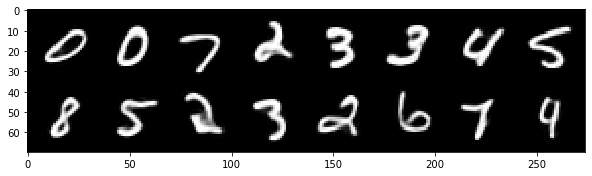

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


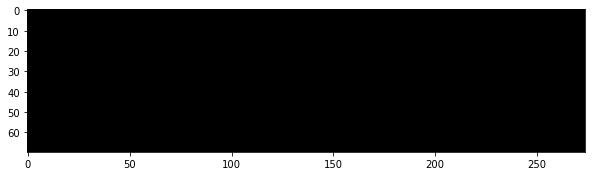

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[1, 5, 9, 1, 7, 0, 0, 3],
        [5, 8, 9, 1, 1, 6, 5, 4]], device='cuda:1')


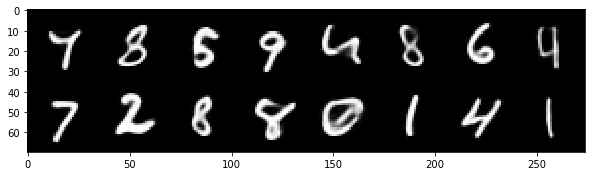

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


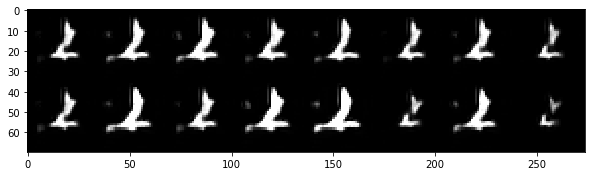

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[1, 1, 3, 9, 2, 4, 0, 3],
        [1, 7, 6, 9, 2, 3, 1, 4]], device='cuda:1')


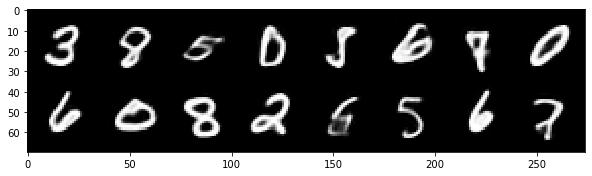

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


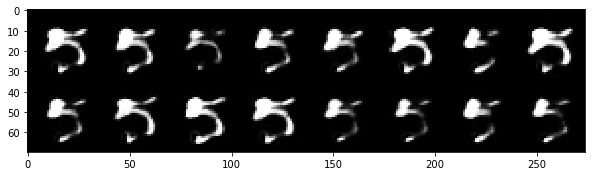

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[9, 9, 2, 6, 3, 2, 8, 6],
        [3, 2, 7, 4, 4, 3, 0, 2]], device='cuda:1')


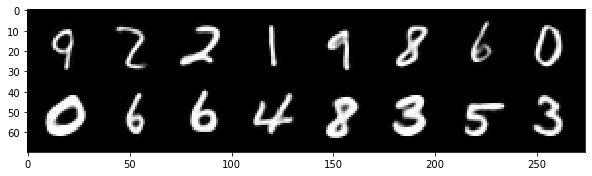

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


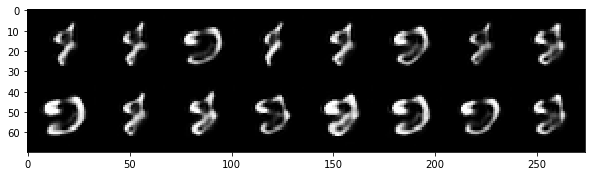

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[9, 8, 3, 3, 0, 7, 2, 0],
        [2, 6, 8, 8, 3, 1, 8, 1]], device='cuda:1')


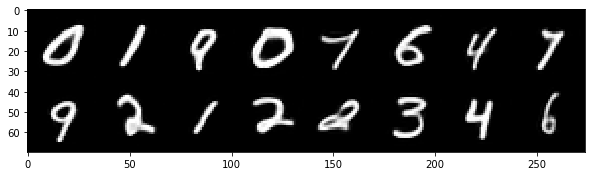

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


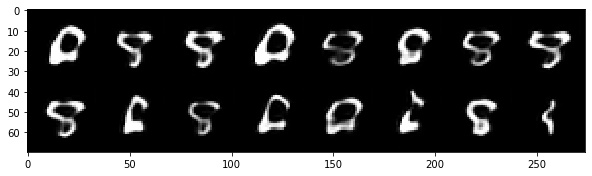

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[2, 1, 6, 6, 4, 7, 2, 5],
        [0, 7, 0, 2, 9, 2, 6, 8]], device='cuda:1')


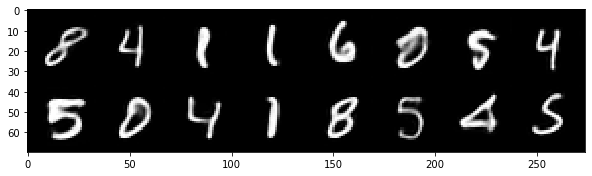

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


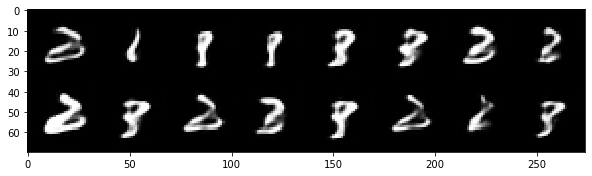

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[3, 4, 3, 9, 0, 3, 9, 5],
        [8, 4, 6, 5, 8, 4, 1, 3]], device='cuda:1')


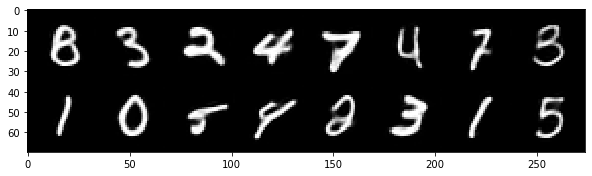

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


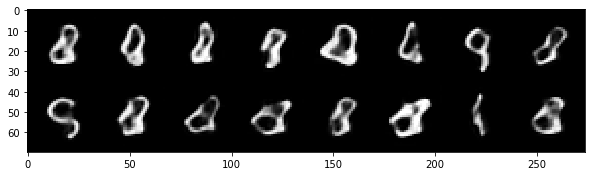

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[9, 2, 4, 3, 4, 2, 5, 4],
        [6, 1, 3, 1, 0, 0, 4, 9]], device='cuda:1')


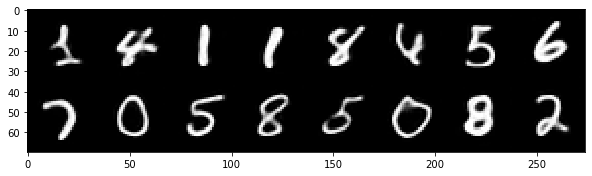

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


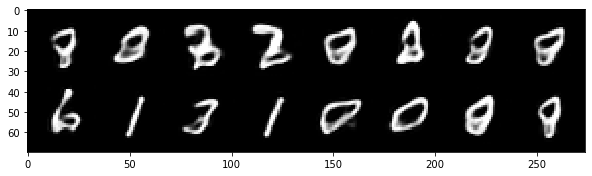

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[0, 8, 3, 9, 9, 3, 6, 9],
        [9, 0, 8, 6, 0, 1, 8, 2]], device='cuda:1')


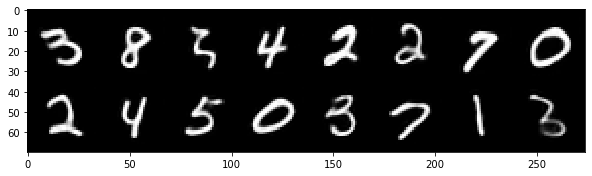

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


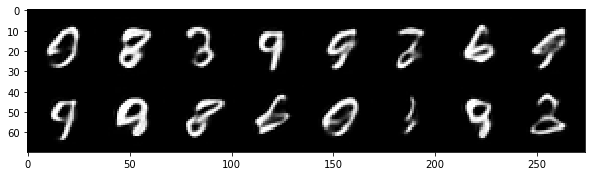

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[6, 0, 9, 9, 5, 0, 8, 9],
        [5, 3, 3, 0, 7, 4, 7, 6]], device='cuda:1')


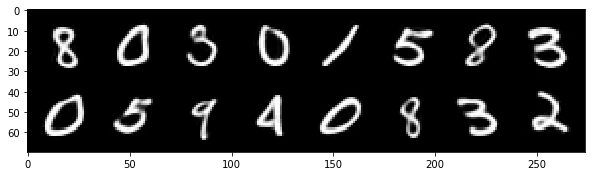

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


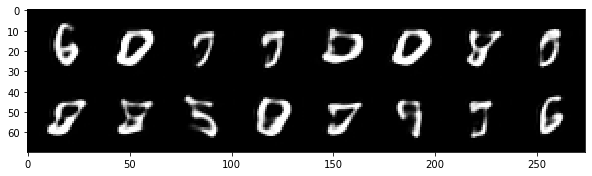

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[2, 5, 1, 9, 4, 1, 5, 6],
        [3, 8, 5, 4, 1, 3, 2, 0]], device='cuda:1')


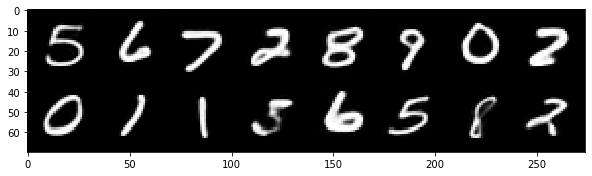

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


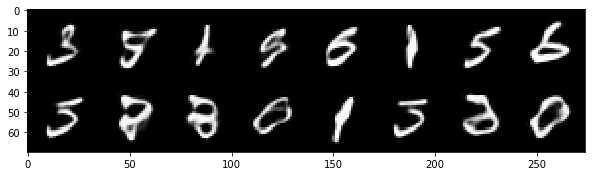

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[7, 8, 0, 8, 9, 2, 1, 5],
        [4, 6, 1, 2, 2, 5, 4, 8]], device='cuda:1')


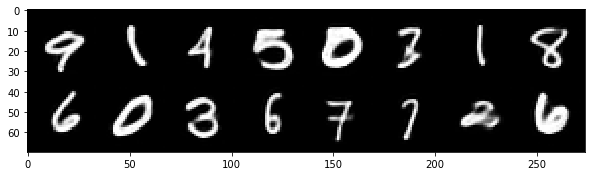

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


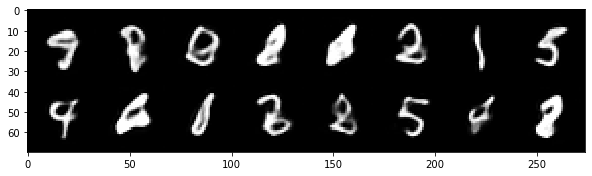

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[6, 2, 3, 1, 9, 1, 6, 5],
        [0, 9, 7, 7, 3, 8, 8, 3]], device='cuda:1')


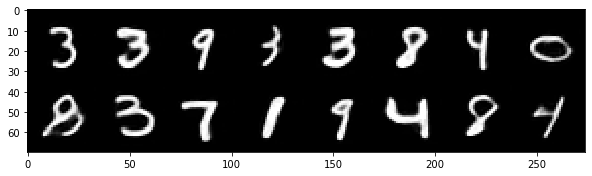

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


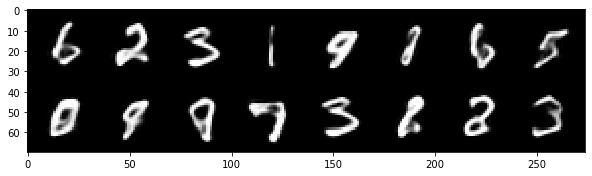

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[8, 7, 4, 5, 7, 4, 2, 4],
        [6, 3, 3, 8, 6, 8, 0, 8]], device='cuda:1')


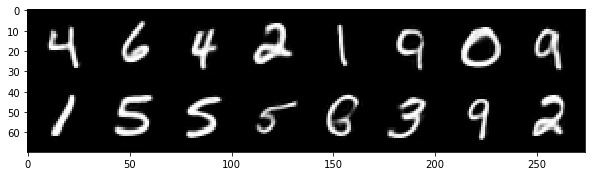

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


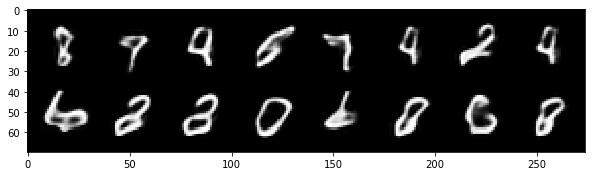

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[8, 8, 2, 6, 6, 1, 0, 0],
        [1, 4, 7, 8, 0, 2, 9, 5]], device='cuda:1')


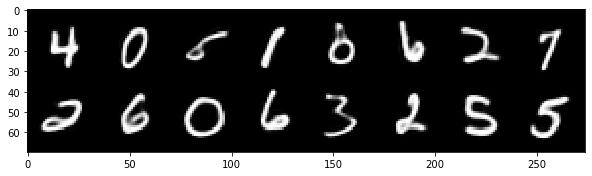

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


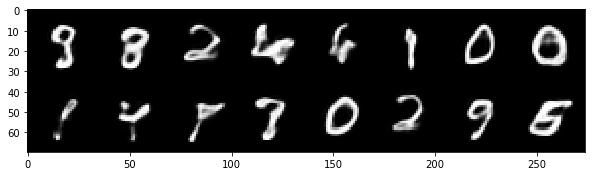

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[9, 1, 2, 4, 6, 8, 9, 7],
        [7, 6, 8, 2, 6, 7, 0, 7]], device='cuda:1')


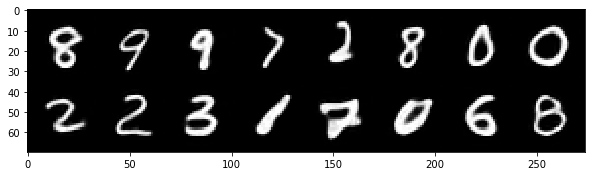

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


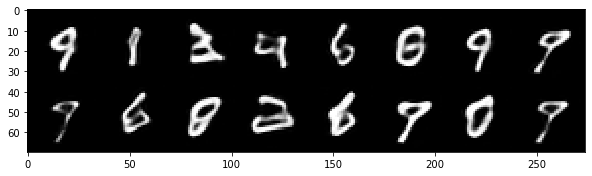

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[8, 7, 8, 8, 9, 4, 7, 2],
        [0, 7, 9, 7, 0, 2, 0, 2]], device='cuda:1')


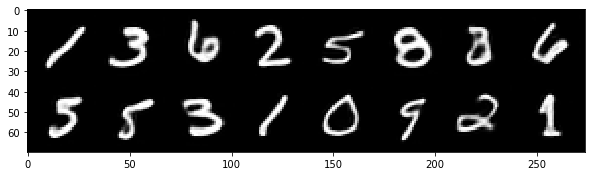

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


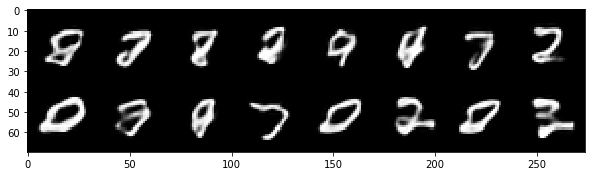

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[4, 1, 5, 1, 6, 9, 9, 0],
        [8, 8, 4, 5, 7, 9, 3, 1]], device='cuda:1')


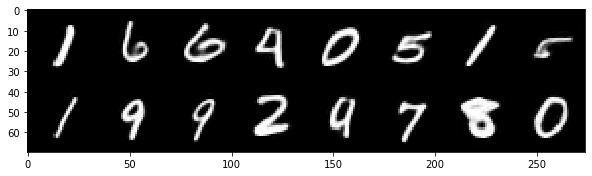

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


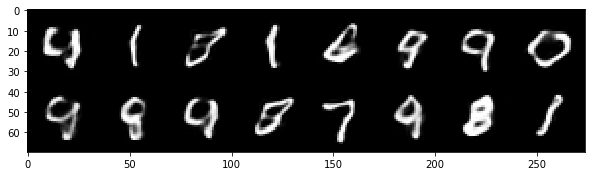

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[6, 6, 9, 4, 4, 4, 4, 8],
        [8, 4, 5, 3, 7, 8, 9, 4]], device='cuda:1')


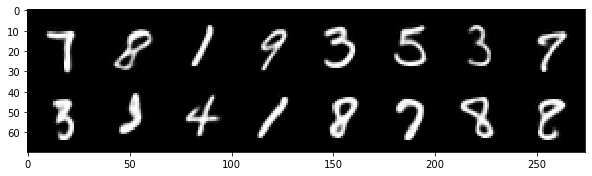

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


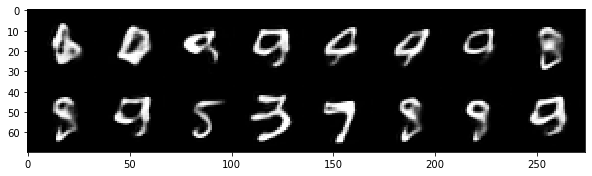

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([[8, 8, 2, 1, 3, 0, 7, 7],
        [7, 4, 8, 7, 9, 8, 2, 6]], device='cuda:1')


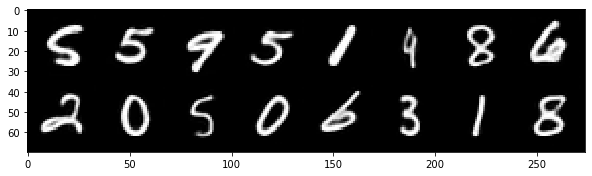

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


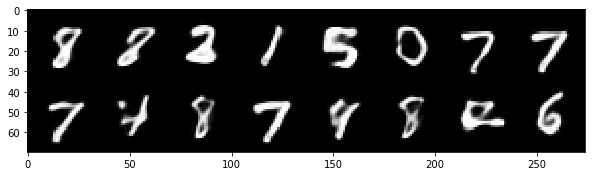

In [267]:
BS = 128

train_dataset = EmbeddingDataset(torch.load('/root/AutoEncoders/MNIST_embedding.pth'), part='train')
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)

z_dim = 32
cat_feature = 10
joint_blocks = 2
BN = False

Gen = LatentGenerator(z_dim, cat_feature, joint_blocks=joint_blocks, bn = BN).to(DEVICE)
Disc = LatentDiscriminator(z_dim, cat_feature, joint_blocks=joint_blocks).to(DEVICE)

BCE = nn.BCEWithLogitsLoss()
cycle = nn.L1Loss()

lmbda = 1 # Cycle

opt_Disc = torch.optim.Adam(Disc.parameters(), lr=2e-4, betas=(0, 0.99))
opt_Gen = torch.optim.Adam(Gen.parameters(), lr=2e-4, betas=(0, 0.99))

batches_tracked = 20_000
loss_D, loss_G, loss_C = [], [], []

for iteration in tqdm(range(batches_tracked), total=batches_tracked):
    
    ####################################
    ############# Disc step ############
    ####################################
    
    batch_disc, label = next(iter(train_loader))
    batch_disc, label = batch_disc.to(DEVICE), label.to(DEVICE)        
        
    pred_real = Disc(batch_disc, label)
    loss_real = BCE(pred_real, torch.ones_like(pred_real).to(DEVICE))
    
    batch_gen, _ = next(iter(train_loader))
    batch_gen = batch_gen.to(DEVICE)
    
    gen_labels = sample_labels(BS).to(DEVICE)
    gen_fake = Gen(batch_gen, gen_labels)
    pred_fake = Disc(gen_fake, gen_labels)
    loss_fake = BCE(pred_fake, torch.zeros_like(pred_fake).to(DEVICE))
    
    loss_Disc = loss_real + loss_fake
    loss_D.append(loss_Disc.item())
    
    opt_Disc.zero_grad()
    loss_Disc.backward()
    opt_Disc.step()
    
    ####################################
    ############# Gen step #############
    ####################################
    
    batch_gen, gen_labels_orig = next(iter(train_loader))
    batch_gen, gen_labels_orig = batch_gen.to(DEVICE), gen_labels_orig.to(DEVICE)
    
    gen_labels = sample_labels(BS).to(DEVICE)
    gen_fake = Gen(batch_gen, gen_labels)
    pred_fake = Disc(gen_fake, gen_labels)
    
    loss_Gen = BCE(pred_fake, torch.ones_like(pred_fake).to(DEVICE))
    loss_cycle = cycle(batch_gen, Gen(gen_fake, gen_labels_orig))
    
    loss_G_total = loss_Gen + loss_cycle.mul(lmbda)
    
    loss_G.append(loss_Gen.item())
    loss_C.append(loss_cycle.item())
    
    opt_Gen.zero_grad()
    loss_Gen.backward()
    opt_Gen.step()
    
    if iteration%1000 == 0:
        show = 16
        
        print('Desired labels:', gen_labels.argmax(dim=1)[:show].reshape(2, -1))        
        rec_original = autoencoder.decoder(batch_gen.reshape(BS, 2, 4, 4)).cpu().detach()[:show]
        plt.figure(figsize=(10, 5))
        plt.imshow(make_grid(rec_original).numpy().transpose((1,2,0)))
        plt.show()
        
        rec_generated = autoencoder.decoder(gen_fake.reshape(BS, 2, 4, 4)).cpu().detach()[:show]
        plt.figure(figsize=(10, 5))
        plt.imshow(make_grid(rec_generated).numpy().transpose((1,2,0)))
        plt.show()

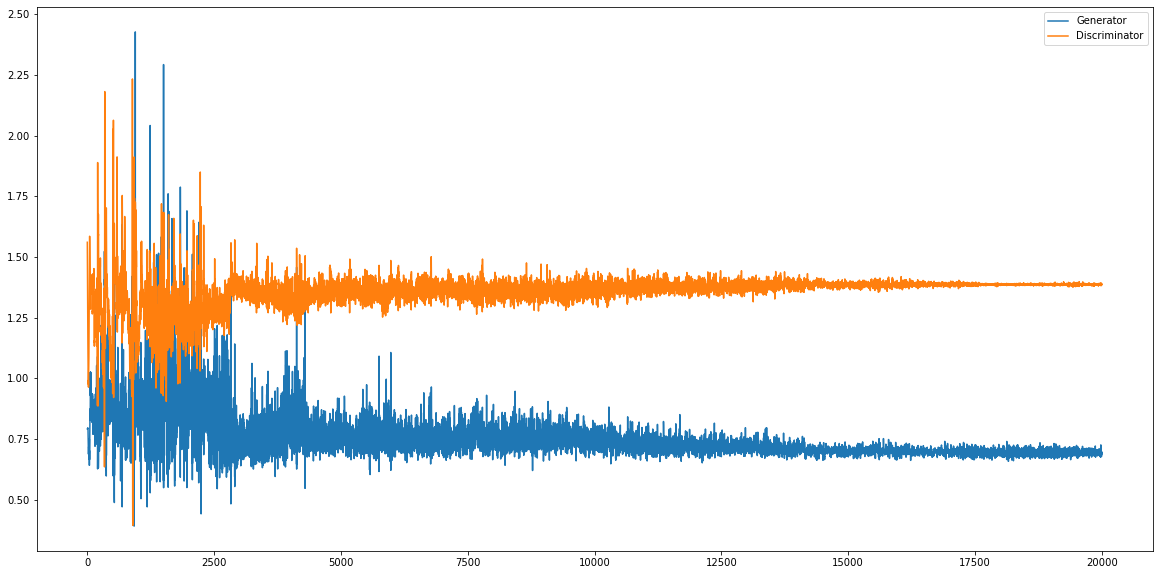

In [245]:
plt.figure(figsize=(20, 10))
plt.plot(loss_G, label='Generator')
plt.plot(loss_D, label='Discriminator')
plt.legend();

In [126]:
import torchvision

In [172]:
with open('/root/data/CelebA/list_attr_celeba.txt') as f:
    content = f.readlines()

content = [[symb for symb in x.strip().split(' ') if symb != ''] for x in content[1:]] 
content_df = pd.DataFrame(content[1:])
content_df.columns = ['path'] + content[0]

In [173]:
content_df.to_csv('CelebA_attributes.csv', index=False)

# `Celeba32`

In [15]:
import pandas as pd
from PIL import Image

class CelebaDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 usecols = ['Black_Hair', 'Blond_Hair'],
                 transofrm = None,
                 attr_file='/root/data/CelebA/list_attr_celeba.txt',
                 dataset_location='/root/data/CelebA/img_align_celeba/'):
        """
        Avaliable attributes
        [0, '5_o_Clock_Shadow'], [1, 'Arched_Eyebrows'],  [2, 'Attractive'],  [3, 'Bags_Under_Eyes'],  [4, 'Bald'],
        [5, 'Bangs'], [6, 'Big_Lips'], [7, 'Big_Nose'], [8, 'Black_Hair'], [9, 'Blond_Hair'], [10, 'Blurry'],
        [11, 'Brown_Hair'], [12, 'Bushy_Eyebrows'], [13, 'Chubby'], [14, 'Double_Chin'], [15, 'Eyeglasses'],
        [16, 'Goatee'], [17, 'Gray_Hair'], [18, 'Heavy_Makeup'], [19, 'High_Cheekbones'], [20, 'Male'],
        [21, 'Mouth_Slightly_Open'], [22, 'Mustache'], [23, 'Narrow_Eyes'], [24, 'No_Beard'], [25, 'Oval_Face'],
        [26, 'Pale_Skin'], [27, 'Pointy_Nose'], [28, 'Receding_Hairline'], [29, 'Rosy_Cheeks'], [30, 'Sideburns'],
        [31, 'Smiling'], [32, 'Straight_Hair'], [33, 'Wavy_Hair'], [34, 'Wearing_Earrings'], [35, 'Wearing_Hat'],
        [36, 'Wearing_Lipstick'], [37, 'Wearing_Necklace'], [38, 'Wearing_Necktie'], [39, 'Young']
        """
        self.dataset_location = dataset_location
        self.usecols = usecols
        
        with open('/root/data/CelebA/list_attr_celeba.txt') as f:
            content = f.readlines()

        content = [[symb for symb in x.strip().split(' ') if symb != ''] for x in content[1:]] 
        content_df = pd.DataFrame(content[1:])
        content_df.columns = ['path'] + content[0]
        
        self.attributes = content_df[['path'] + usecols]
        self.attributes[usecols] = self.attributes[usecols].astype(float)
        self.attributes = self.attributes[(self.attributes[usecols[0]] == 1) | (self.attributes[usecols[1]] == 1)]
        
        self.transofrm = transofrm
        
    def __len__(self):
        return len(self.attributes)
    
    def __getitem__(self, idx):
        person = self.attributes.iloc[idx]
        
        attributes = np.maximum(person[self.usecols].values, 0)
        img = Image.open(os.path.join(self.dataset_location, person['path']))
        
        return (self.transofrm(img), torch.Tensor(attributes.tolist()))

## `Dataloading`

In [5]:
class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, emb):
        self.embedding = emb
                
    def __len__(self):
        return len(self.embedding)
    
    def __getitem__(self, idx):
        obj = self.embedding[idx]
                
        return (obj[:-2], obj[-2:].float())

# `Load AE`

In [7]:
import math

In [8]:
from modules import Autoencoder

args={'eval_each': 10,    'epochs': 101,    'batch_norm': False,     'colors': 3,     'device': 'cuda:3',  
      'latent_width': 4,     'lmbda': 0.5,    'weight_decay': 1e-05,     'batch_size': 64,     'width': 64,  
      'depth': 16,     'advdepth': 16,
      'latent': 16,     'lr': 0.0001,     'gamma': 0.2}

scales = int(round(math.log(args['width'] // args['latent_width'], 2)))
autoencoder = Autoencoder(scales=scales,depth=args['depth'],latent=args['latent'],colors=args['colors'])

autoencoder.load_state_dict(torch.load('/root/AutoEncoders/CelebA32_128/acai.pt')['AE'])

<All keys matched successfully>

# For `loop`

In [12]:
DEVICE = 'cuda:3'

In [13]:
def sample_labels(bs, N_CLASSES=10):
    return nn.functional.one_hot(torch.randint(low=0,high=N_CLASSES, size=(bs,)).long(), num_classes=N_CLASSES).float()

In [81]:
# BS = 128

# train_dataset = CelebaDataset(usecols = ['Black_Hair', 'Blond_Hair'],
#                               transofrm=torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)),
#                                                                         torchvision.transforms.RandomHorizontalFlip(),
#                                                                         torchvision.transforms.ToTensor()]))
# train_loader = DataLoader(train_dataset, batch_size=128, num_workers=4, shuffle=True)

BS = 128

train_dataset = EmbeddingDataset(torch.load('Embedding_CelebA32.pth'))
train_loader = DataLoader(train_dataset, batch_size=BS, num_workers=4, shuffle=True)

In [82]:
from time import time

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([1, 0, 1, 1, 1, 1, 1, 0], device='cuda:3')


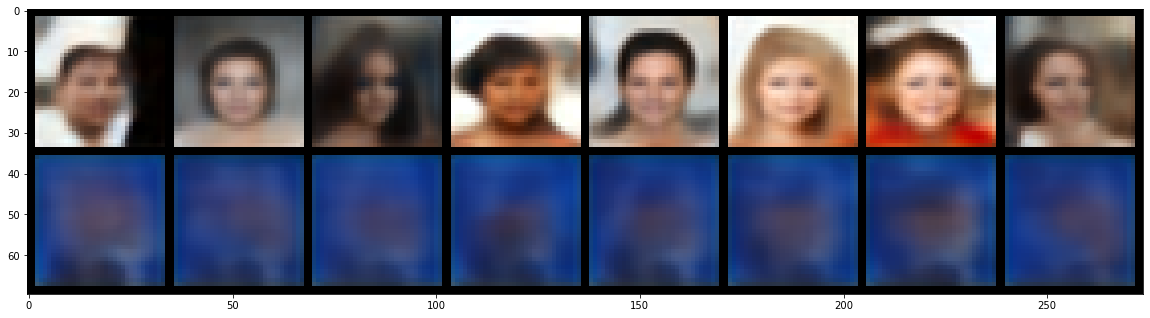

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:3')


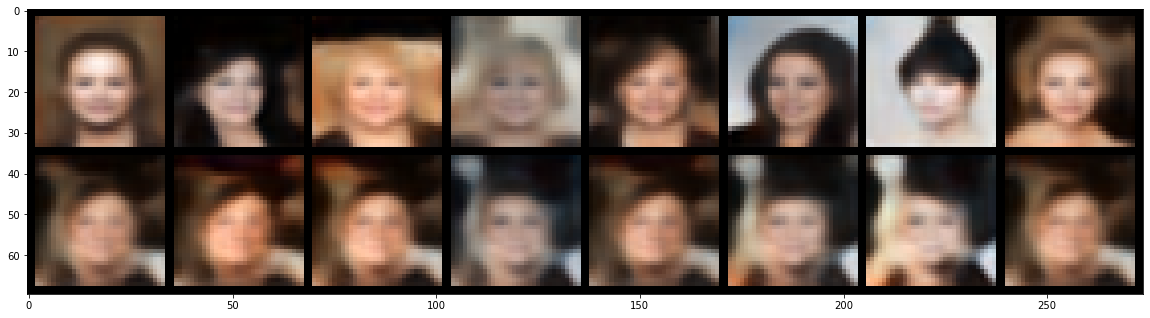

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([1, 1, 1, 1, 0, 1, 0, 1], device='cuda:3')


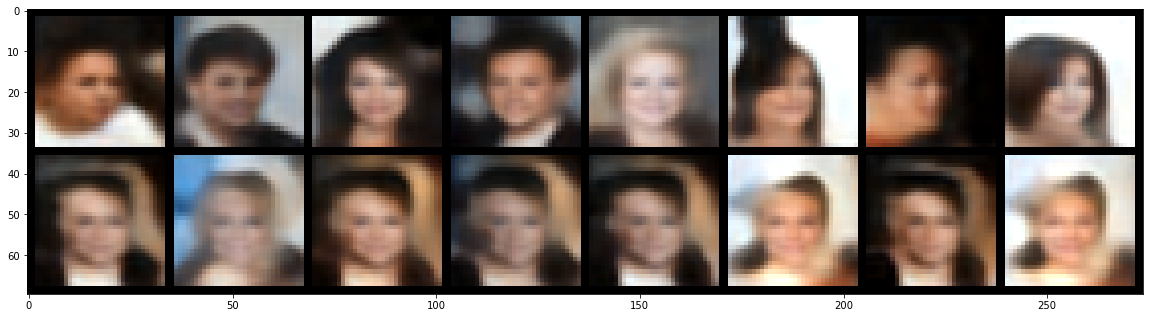

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:3')


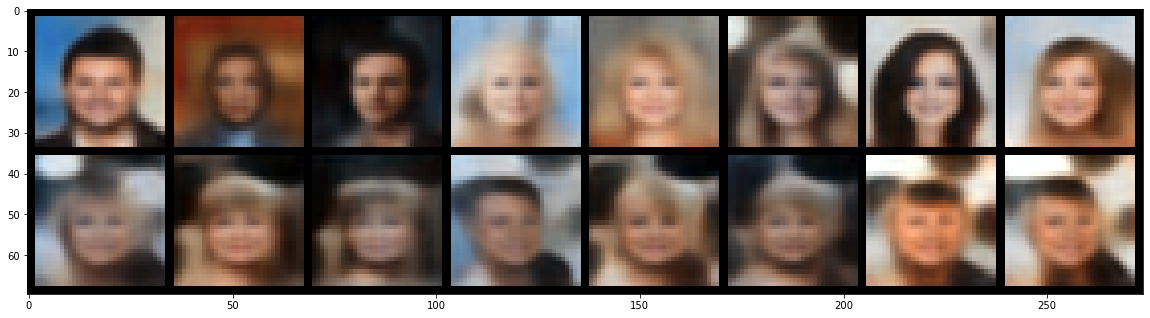

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([1, 0, 0, 1, 1, 0, 0, 1], device='cuda:3')


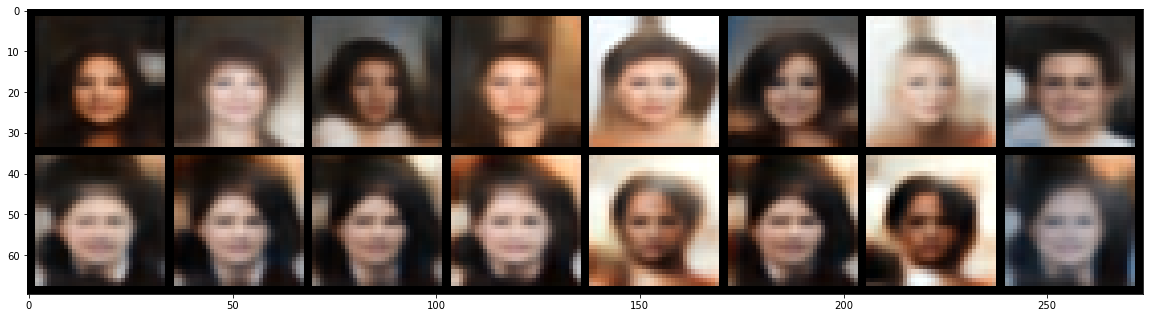

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([0, 1, 1, 1, 1, 1, 1, 1], device='cuda:3')


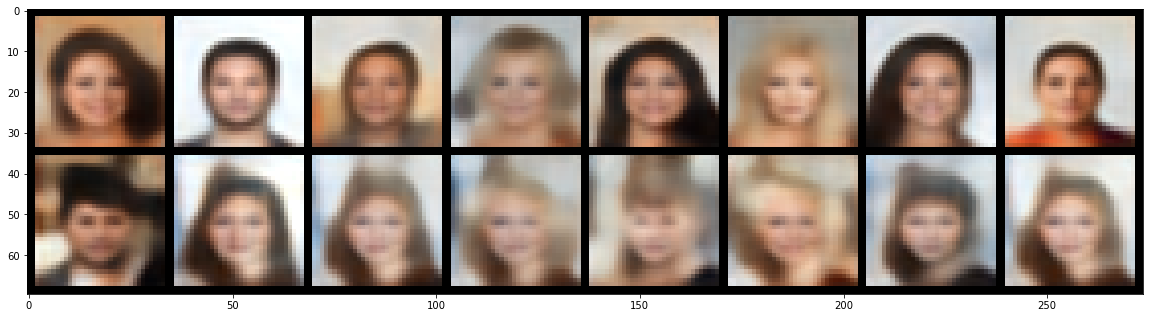

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([1, 0, 0, 0, 1, 1, 0, 1], device='cuda:3')


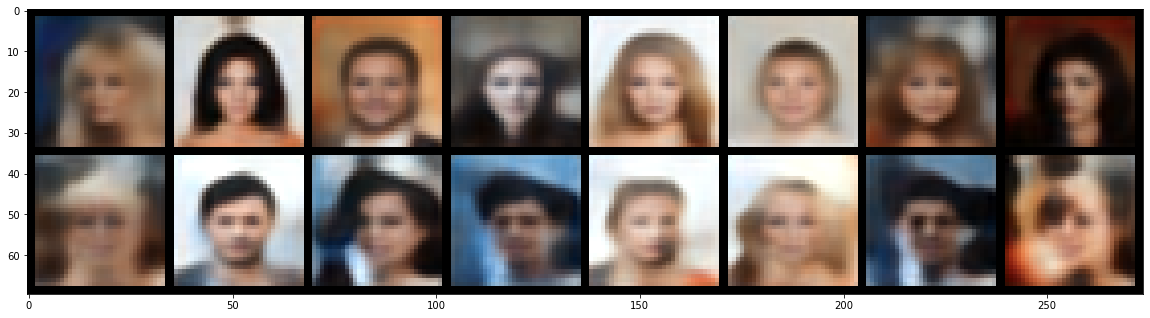

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:3')


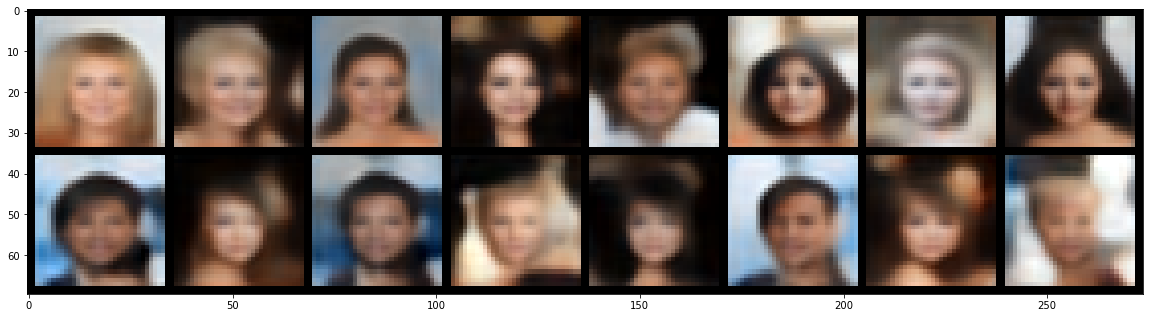

Desired labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:3')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


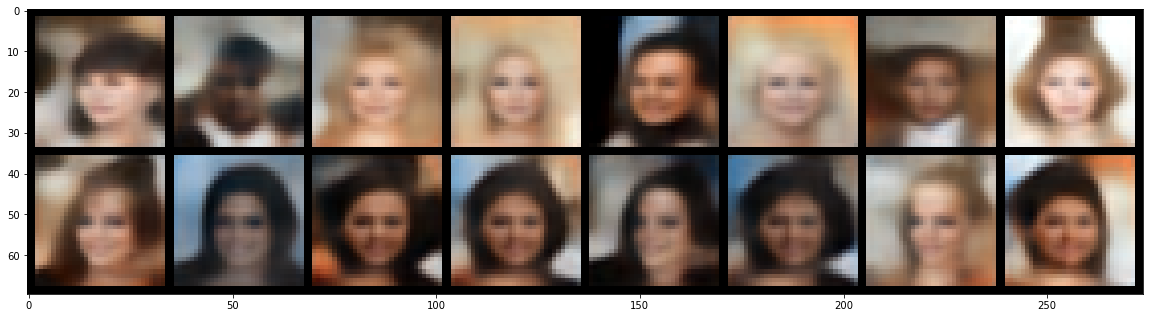

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:3')


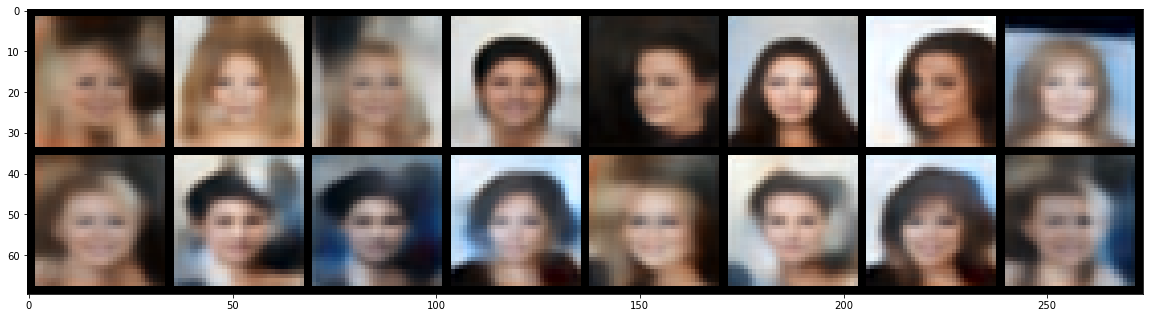

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:3')


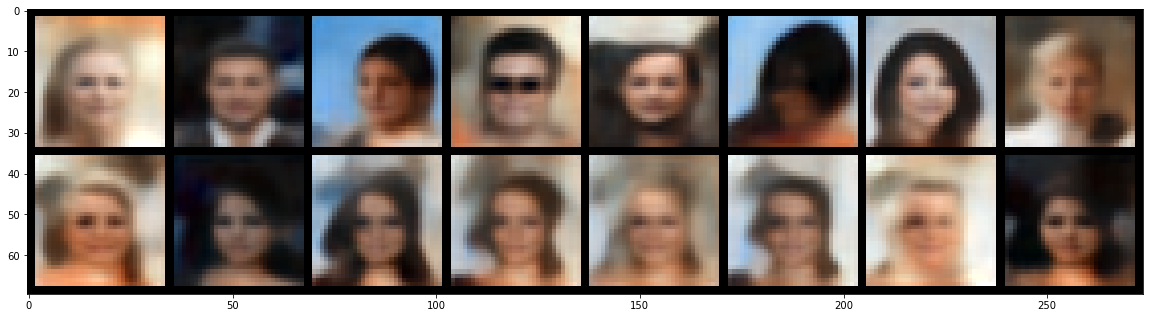

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([0, 1, 1, 0, 0, 0, 1, 1], device='cuda:3')


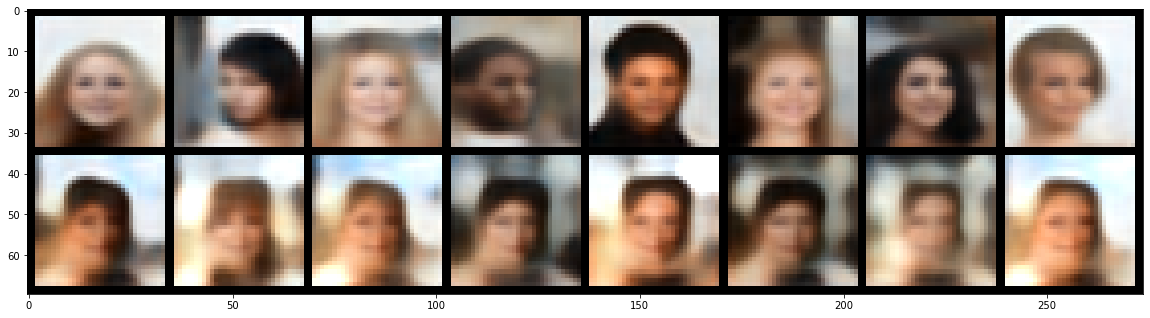

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:3')


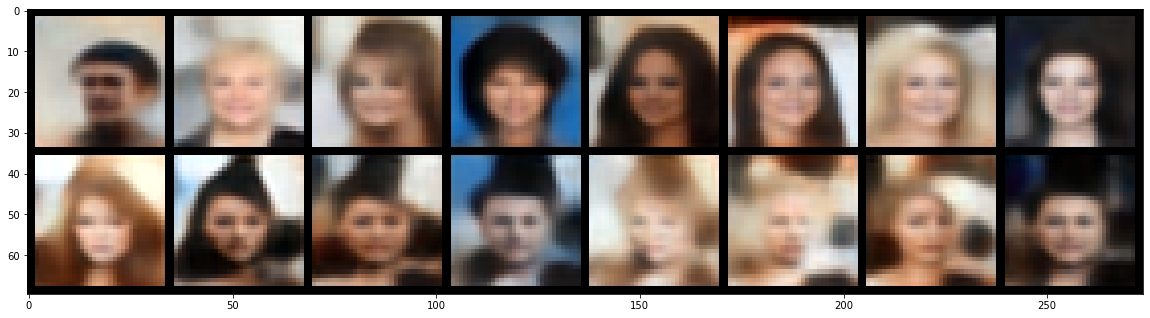

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([1, 1, 1, 0, 1, 1, 1, 1], device='cuda:3')


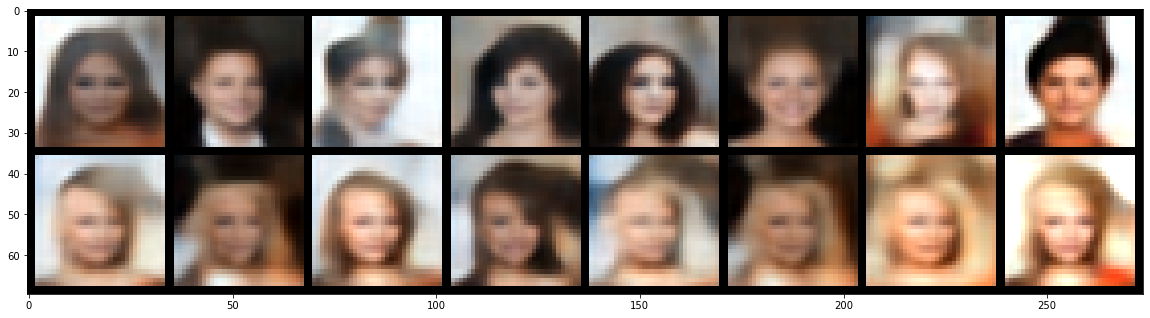

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([0, 1, 0, 1, 1, 1, 0, 1], device='cuda:3')


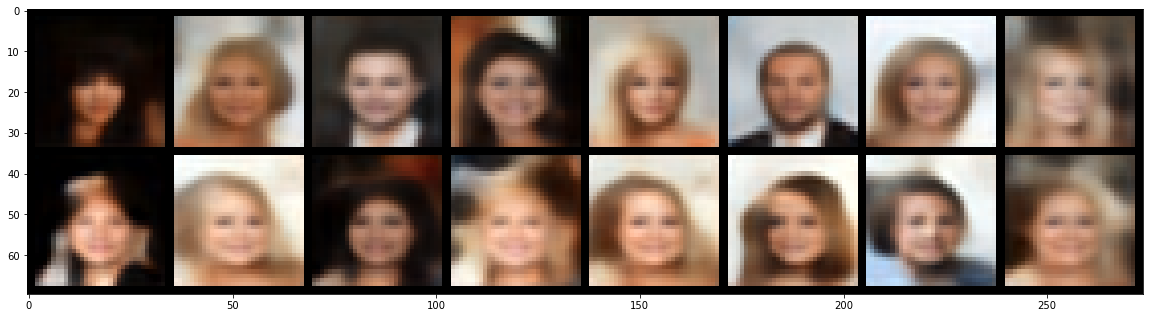

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([1, 0, 0, 1, 1, 1, 1, 1], device='cuda:3')


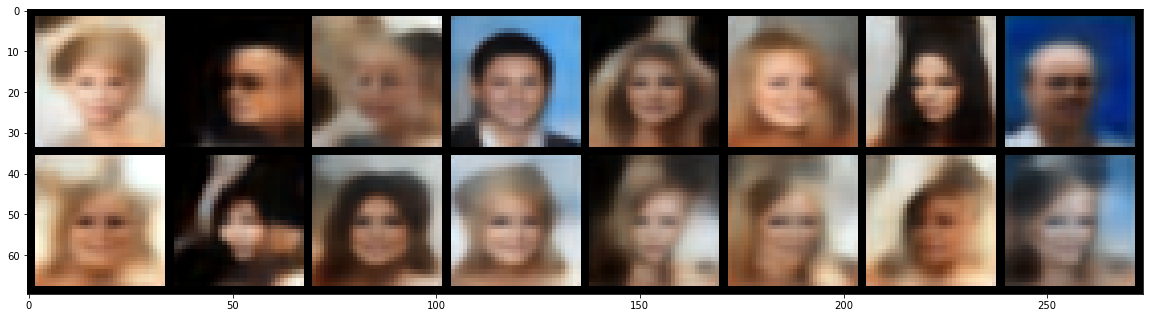

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:3')


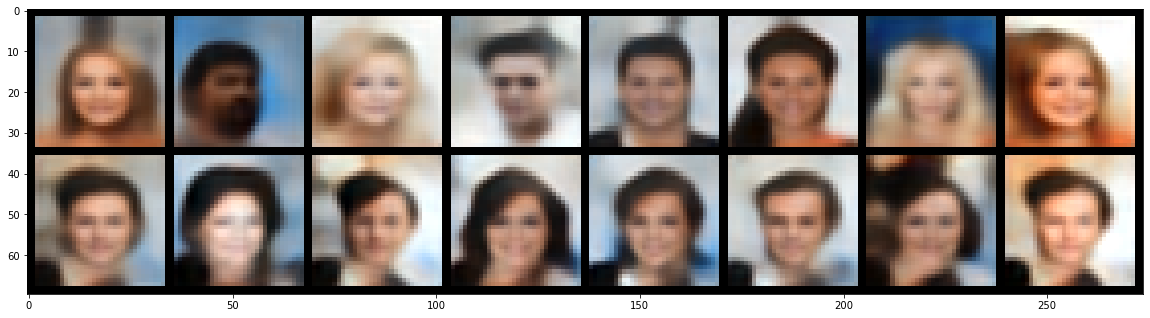

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:3')


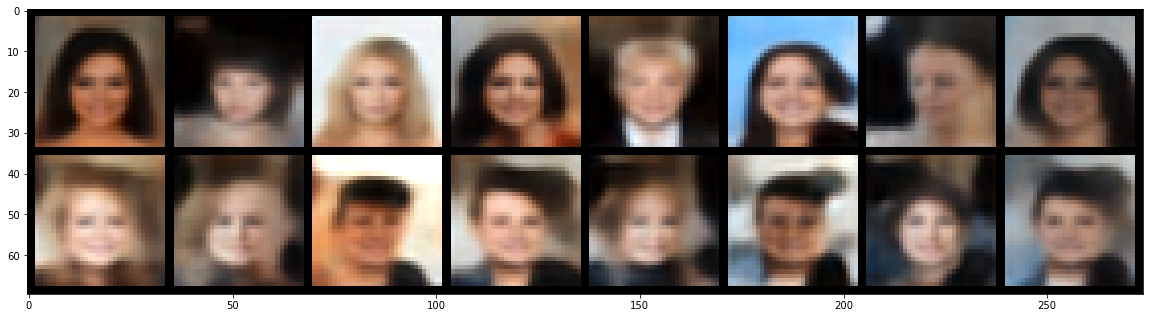

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([0, 0, 1, 0, 1, 1, 0, 1], device='cuda:3')


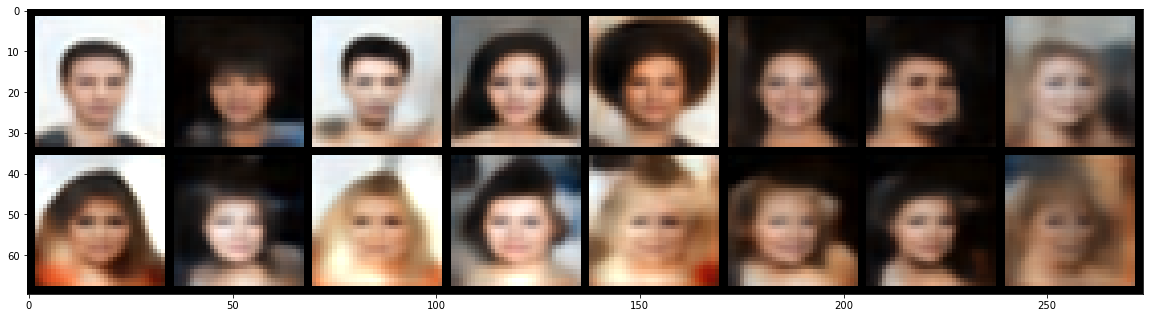

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:3')


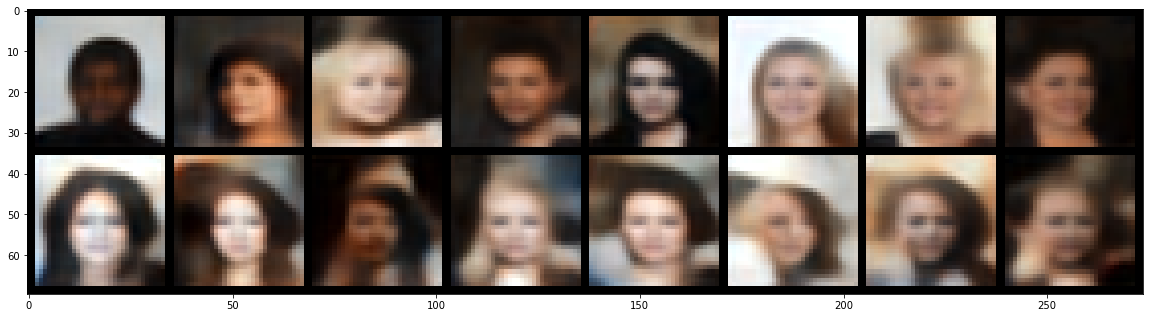

KeyboardInterrupt: 

In [94]:
z_dim = 64
cat_feature = 2
joint_blocks = 1
BN = False
RATIO = 1/8


Gen = LatentGenerator(z_dim, cat_feature, ratio=RATIO, joint_blocks=joint_blocks, bn = BN).to(DEVICE)
Disc = LatentDiscriminator(z_dim, cat_feature, ratio=RATIO, joint_blocks=joint_blocks).to(DEVICE)

BCE = nn.BCEWithLogitsLoss()
cycle = nn.L1Loss()

lmbda = 10 # Cycle

opt_Disc = torch.optim.Adam(Disc.parameters(), lr=1e-4, betas=(0, 0.99))
opt_Gen = torch.optim.Adam(Gen.parameters(), lr=1e-4, betas=(0, 0.99))

batches_tracked = 20_000
loss_D, loss_G, loss_C = [], [], []

autoencoder = autoencoder.to(DEVICE)
autoencoder.eval();

iter_loader = iter(train_loader)

for iteration in tqdm(range(batches_tracked), total=batches_tracked):
    
    ####################################
    ############# Disc step ############
    ####################################
    
    t = time()
    
    batch_disc, label = next(iter_loader)
    batch_disc, label = batch_disc.to(DEVICE), label.to(DEVICE) 
    
    pred_real = Disc(batch_disc, label)
    loss_real = BCE(pred_real, torch.ones_like(pred_real).to(DEVICE))
    
    batch_gen, _ = next(iter_loader)
    batch_gen = batch_gen.to(DEVICE)
    
    gen_labels = sample_labels(BS, N_CLASSES=cat_feature).to(DEVICE)
    gen_fake = Gen(batch_gen, gen_labels)
    pred_fake = Disc(gen_fake, gen_labels)
    loss_fake = BCE(pred_fake, torch.zeros_like(pred_fake).to(DEVICE))
    
    loss_Disc = loss_real + loss_fake
    loss_D.append(loss_Disc.item())
    
#     print('Disc forward:', time() - t)
    
    opt_Disc.zero_grad()
    loss_Disc.backward()
    opt_Disc.step()
    
#     print('Disc backward:', time() - t)
    
    ####################################
    ############# Gen step #############
    ####################################
    
    batch_gen, gen_labels_orig = next(iter_loader)
    batch_gen, gen_labels_orig = batch_gen.to(DEVICE), gen_labels_orig.to(DEVICE)
    
    gen_labels = sample_labels(BS, N_CLASSES=cat_feature).to(DEVICE)
    gen_fake = Gen(batch_gen, gen_labels)
    pred_fake = Disc(gen_fake, gen_labels)
    
    loss_Gen = BCE(pred_fake, torch.ones_like(pred_fake).to(DEVICE))
    loss_cycle = cycle(batch_gen, Gen(gen_fake, gen_labels_orig))
    
    loss_G_total = loss_Gen + loss_cycle.mul(lmbda)
    
    loss_G.append(loss_Gen.item())
    loss_C.append(loss_cycle.item())
    
#     print('Gen forward:', time() - t)
    
    opt_Gen.zero_grad()
    loss_Gen.backward()
    opt_Gen.step()
    
#     print('Gen backward:', time() - t)


    if iteration %200 ==0:
        iter_loader = iter(train_loader)        
    
    
    if iteration%1000 == 0:
        show = 8
        
        print('Desired labels:', gen_labels.argmax(dim=1)[:show].reshape(-1))        
        rec_original = autoencoder.decoder(batch_gen.reshape(BS, 16, 2, 2)).cpu().detach()[:show]
        rec_generated = autoencoder.decoder(gen_fake.reshape(BS, 16, 2, 2)).cpu().detach()[:show]
        
        plt.figure(figsize=(20, 10))
        plt.imshow(make_grid(torch.cat([rec_original, rec_generated], dim=0)).numpy().transpose((1,2,0)))
        plt.show()

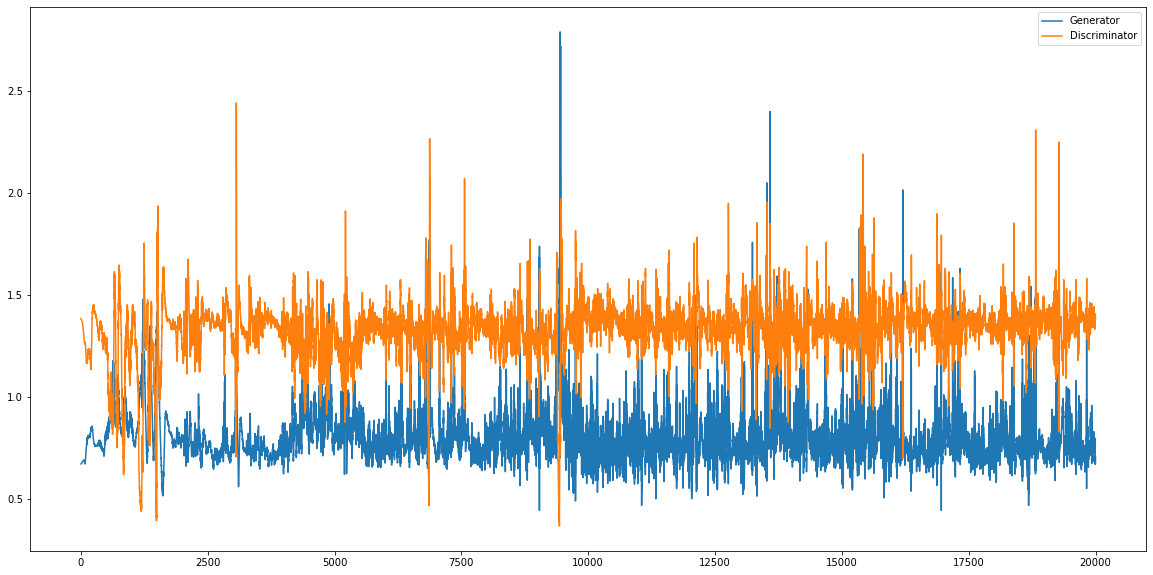

In [93]:
plt.figure(figsize=(20, 10))
plt.plot(loss_G, label='Generator')
plt.plot(loss_D, label='Discriminator')
plt.legend();

In [49]:
iter_loader = iter(train_loader)

In [53]:
matrix = []

for batch, label in iter_loader:
    batch = batch.to(DEVICE)
    
    with torch.no_grad():
        emb = autoencoder.encoder(batch).reshape(batch.shape[0], -1).detach().cpu()
    
    matrix.append(torch.cat([emb, label], dim=-1))

In [56]:
# torch.save(torch.cat(matrix), 'Embedding_CelebA32.pth')

# `Celeba64`

In [6]:
import math

In [7]:
from modules import Autoencoder

args=args =  {'dataset': 'MNIST', 'eval_each': 10, 'epochs': 101, 'log_dir': 'CelebA64_256_v2/', 'device': 'cuda:7',
         'weight_decay': 1e-05, 'depth': 16, 'gamma': 0.2, 'lmbda': 0.5, 'batch_norm': False, 'batch_size': 64,
         'colors': 3, 'latent_width': 4, 'width': 128, 'latent': 32, 'n_classes': 10,'advdepth': 16, 'lr': 0.0001}

scales = int(round(math.log(args['width'] // args['latent_width'], 2)))
autoencoder = Autoencoder(scales=scales,depth=args['depth'],latent=args['latent'],colors=args['colors'])

autoencoder.load_state_dict(torch.load('/root/AutoEncoders/CelebA64_256_v2/ae.pt'))
autoencoder.to(DEVICE);

In [ ]:
train_dataset = CelebaDataset(usecols = ['Black_Hair', 'Blond_Hair'],
                              transofrm=torchvision.transforms.Compose([torchvision.transforms.Resize((64, 64)),
                                                                        torchvision.transforms.RandomHorizontalFlip(),
                                                                        torchvision.transforms.ToTensor()]))
train_loader = DataLoader(train_dataset, batch_size=128, num_workers=4, shuffle=True)

In [109]:
iter_loader = iter(train_loader)

matrix = []

for batch, label in iter_loader:
    batch = batch.to(DEVICE)
    
    with torch.no_grad():
        emb = autoencoder.encoder(batch).reshape(batch.shape[0], -1).detach().cpu()
    
    matrix.append(torch.cat([emb, label], dim=-1))
    
# torch.save(torch.cat(matrix), 'Embedding_CelebA64.pth')

In [198]:
BS = 128

train_dataset = EmbeddingDataset(torch.load('Embedding_CelebA64.pth'))
train_loader = DataLoader(train_dataset, batch_size=BS, num_workers=4, shuffle=True)

In [10]:
for drop in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print(f'Current drop {drop}')
    
    
    z_dim = 128
    cat_feature = 2
    joint_blocks = 4

    BN = False
    RATIO = 0.5
#     drop = 0.5

    Gen = LatentGenerator(z_dim, cat_feature, ratio=RATIO, joint_blocks=joint_blocks, bn = BN, drop=drop).to(DEVICE)
    Disc = LatentDiscriminator(z_dim, cat_feature, ratio=RATIO, joint_blocks=joint_blocks, drop=drop).to(DEVICE)

    BCE = nn.BCEWithLogitsLoss()
    cycle = nn.L1Loss()

    lmbda = 10 # Cycle

    opt_Disc = torch.optim.Adam(Disc.parameters(), lr=1e-4, betas=(0, 0.99))
    opt_Gen = torch.optim.Adam(Gen.parameters(), lr=1e-4, betas=(0, 0.99))

    batches_tracked = 20_000
    loss_D, loss_G, loss_C = [], [], []

    std_m_, std_w_ = [], []

    autoencoder = autoencoder.to(DEVICE)
    autoencoder.eval();

    iter_loader = iter(train_loader)

    for iteration in tqdm(range(batches_tracked), total=batches_tracked):

        ####################################
        ############# Disc step ############
        ####################################

        t = time()

        batch_disc, label = next(iter_loader)
        batch_disc, label = batch_disc.to(DEVICE), label.to(DEVICE) 

        pred_real = Disc(batch_disc, label)
        loss_real = BCE(pred_real, torch.ones_like(pred_real).to(DEVICE))

        batch_gen, _ = next(iter_loader)
        batch_gen = batch_gen.to(DEVICE)

        gen_labels = sample_labels(BS, N_CLASSES=cat_feature).to(DEVICE)
        gen_fake = Gen(batch_gen, gen_labels)
        pred_fake = Disc(gen_fake, gen_labels)
        loss_fake = BCE(pred_fake, torch.zeros_like(pred_fake).to(DEVICE))

        loss_Disc = loss_real + loss_fake
        loss_D.append(loss_Disc.item())

    #     print('Disc forward:', time() - t)

        opt_Disc.zero_grad()
        loss_Disc.backward()
        opt_Disc.step()

    #     print('Disc backward:', time() - t)

        ####################################
        ############# Gen step #############
        ####################################

        batch_gen, gen_labels_orig = next(iter_loader)
        batch_gen, gen_labels_orig = batch_gen.to(DEVICE), gen_labels_orig.to(DEVICE)

        gen_labels = sample_labels(BS, N_CLASSES=cat_feature).to(DEVICE)
        gen_fake = Gen(batch_gen, gen_labels)
        pred_fake = Disc(gen_fake, gen_labels)

        loss_Gen = BCE(pred_fake, torch.ones_like(pred_fake).to(DEVICE))
        loss_cycle = cycle(batch_gen, Gen(gen_fake, gen_labels_orig))


        girl = gen_fake[gen_labels[:, 0] == 1]
        girl_std = -(girl - girl.mean(dim=0, keepdims=True)).pow(2).sum()

        men = gen_fake[gen_labels[:, 1] == 1]
        men_std = -(men - men.mean(dim=0, keepdims=True)).pow(2).sum()

        loss_G_total = loss_Gen + loss_cycle.mul(lmbda) + men_std.mul(lmbda) + girl_std.mul(lmbda)

        std_m_.append(girl_std.item())
        std_w_.append(men_std.item())

        loss_G.append(loss_Gen.item())
        loss_C.append(loss_cycle.item())

    #     print('Gen forward:', time() - t)

        opt_Gen.zero_grad()
        loss_Gen.backward()
        opt_Gen.step()

    #     print('Gen backward:', time() - t)


        if iteration %200 ==0:
            iter_loader = iter(train_loader)        


#         if iteration%1000 == 0:
#             show = 8

#             print('Desired labels:', gen_labels.argmax(dim=1)[:show].reshape(-1))        
#             rec_original = autoencoder.decoder(batch_gen.reshape(BS, 32, 2, 2)).cpu().detach()[:show]
#             rec_generated = autoencoder.decoder(gen_fake.reshape(BS, 32, 2, 2)).cpu().detach()[:show]

#             plt.figure(figsize=(20, 10))
#             plt.imshow(make_grid(torch.cat([rec_original, rec_generated], dim=0)).numpy().transpose((1,2,0)))
#             plt.show()
            
    torch.save(Gen.state_dict(), f'LatentGenrator_Drop_HairColor{drop}.pth')

Current drop 0



Current drop 0.1



Current drop 0.2



Current drop 0.3



Current drop 0.4



Current drop 0.5



Current drop 0.6



Current drop 0.7



Current drop 0.8



Current drop 0.9


## `Hair color`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


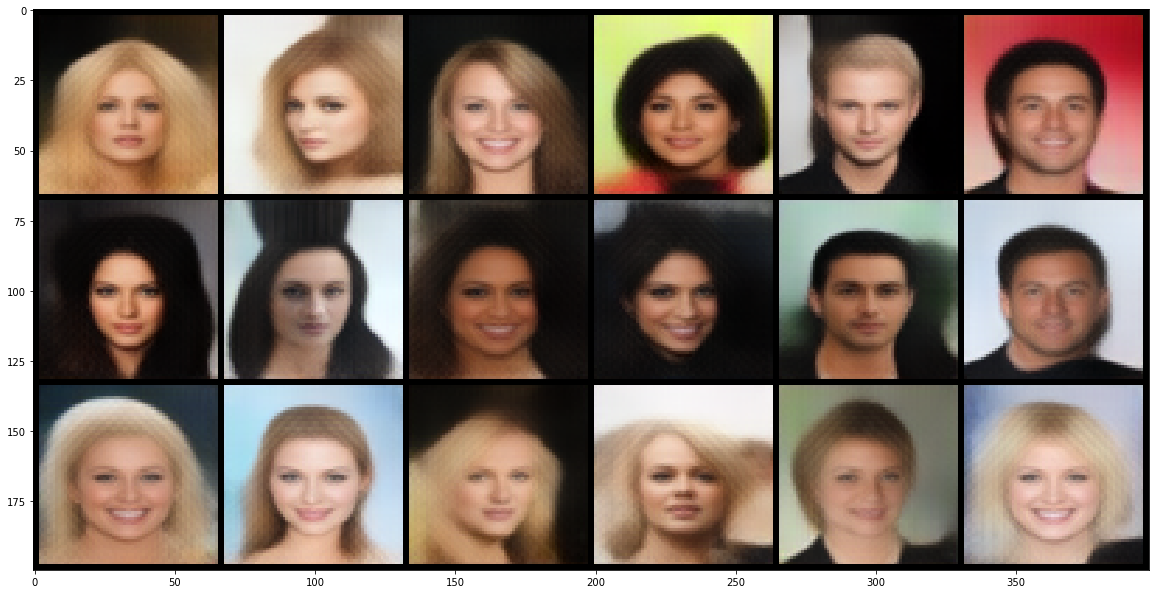

In [338]:
z_dim = 128
cat_feature = 2
joint_blocks = 4

BN = False
RATIO = 0.5

blonds = []
browns = []

for drop in [0.4]:
    
    Gen = LatentGenerator(z_dim, cat_feature, ratio=RATIO, joint_blocks=joint_blocks, bn = BN, drop=drop)
    Gen.load_state_dict(torch.load(f'LatentGenrator_Drop_HairColor{drop}.pth'))
    Gen = Gen.to(DEVICE)
    
    blonds.append(Gen(pool, gen_labels[:6]))
    browns.append(Gen(pool, gen_labels[6:]))
    
rec_original = autoencoder.decoder(pool.reshape(6, 32, 2, 2)).cpu().detach()

blonds = autoencoder.decoder(torch.cat(blonds).reshape(6, 32, 2, 2)).cpu().detach()
browns = autoencoder.decoder(torch.cat(browns).reshape(6, 32, 2, 2)).cpu().detach()

plt.figure(figsize=(20, 20))
plt.imshow(make_grid(torch.cat([rec_original, blonds[:6], browns[:6]], dim=0), nrow=6).numpy().transpose((1,2,0)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


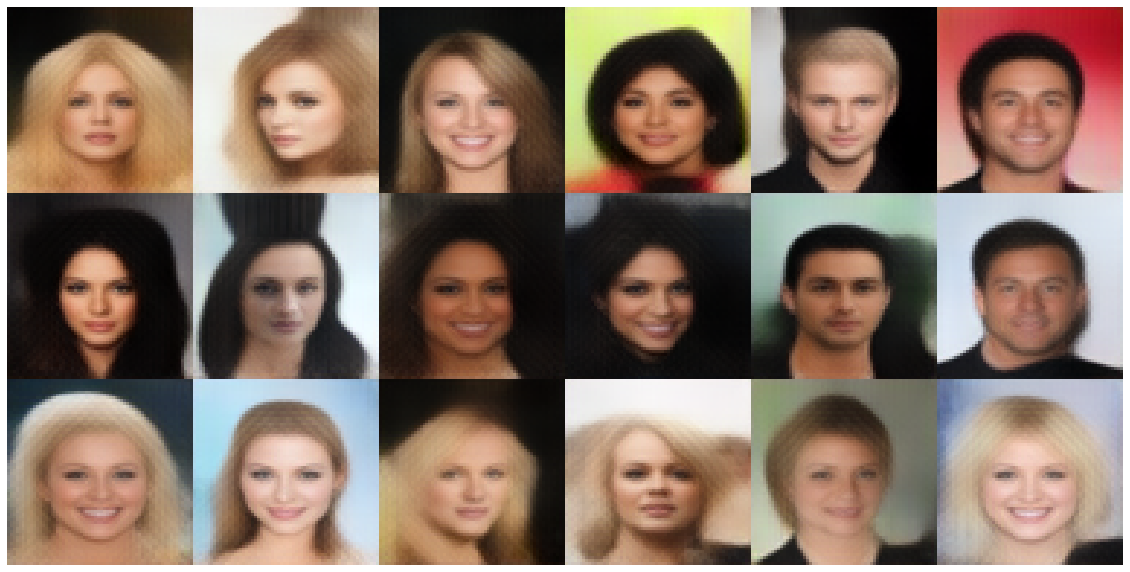

In [340]:
plt.figure(figsize=(20, 20))
plt.imshow(make_grid(torch.cat([rec_original, blonds[:6], browns[:6]], dim=0), nrow=6, padding=0).numpy().transpose((1,2,0)))

plt.axis('off')
plt.savefig('blong_vova.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


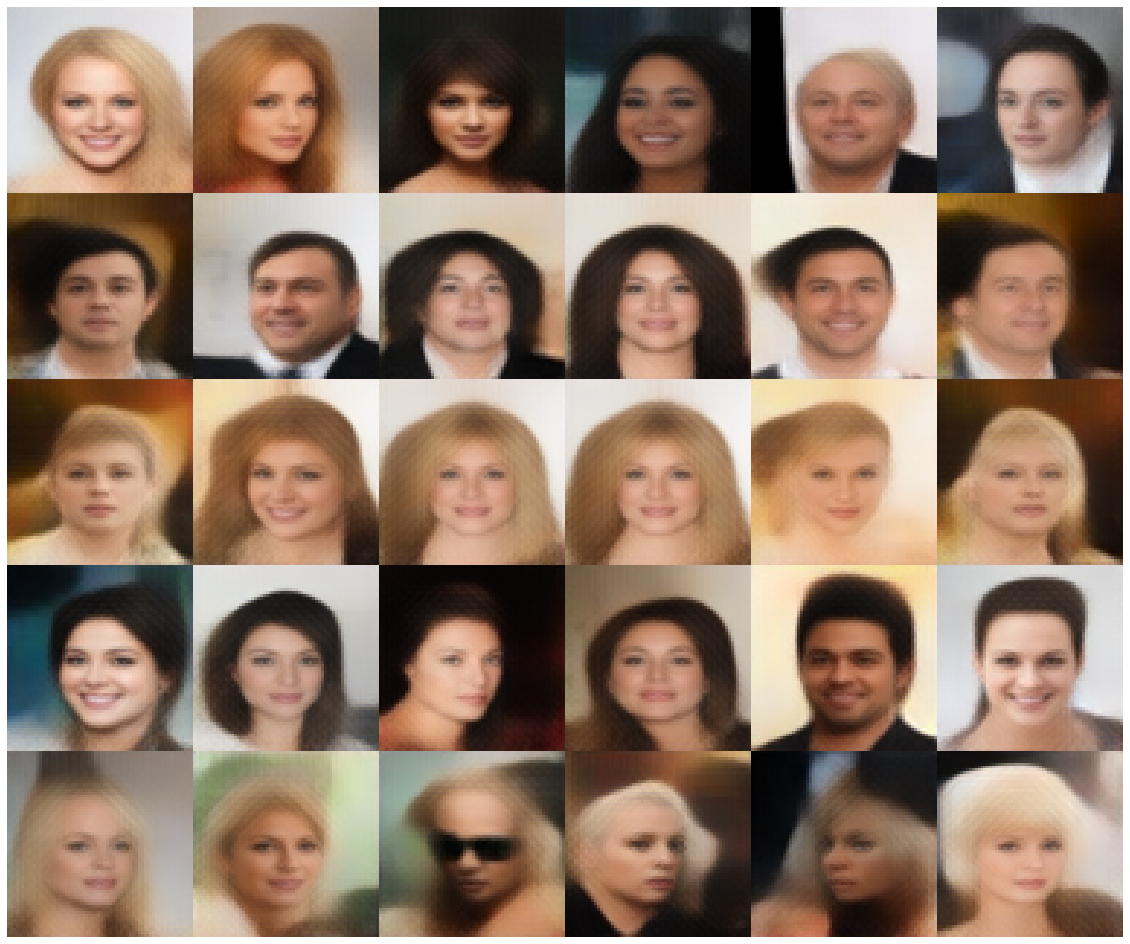

In [253]:
plt.figure(figsize=(20, 20))
plt.imshow(make_grid(torch.cat([rec_original, blonds[:6], browns[:6],\
                                blonds[6:], browns[6:]], dim=0), nrow=6, padding=0).numpy().transpose((1,2,0)))
plt.axis('off')
# plt.savefig('blong.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


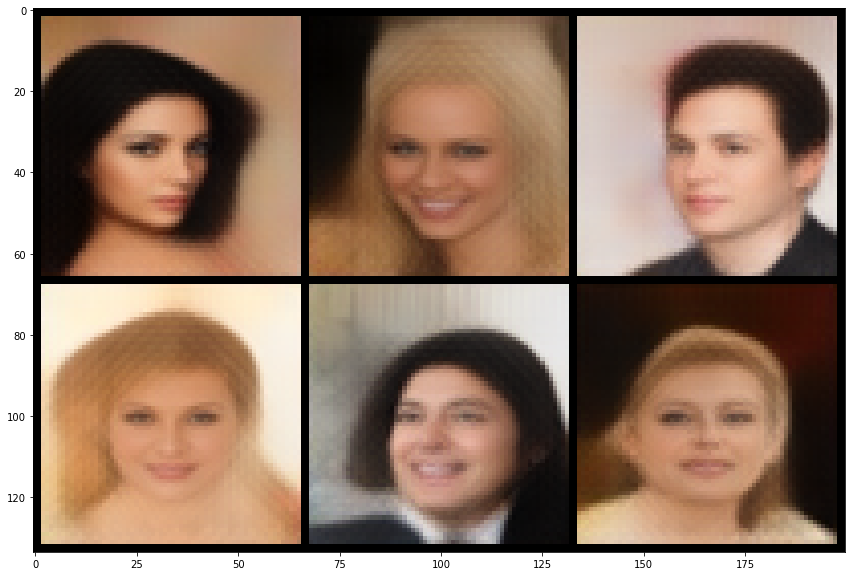

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


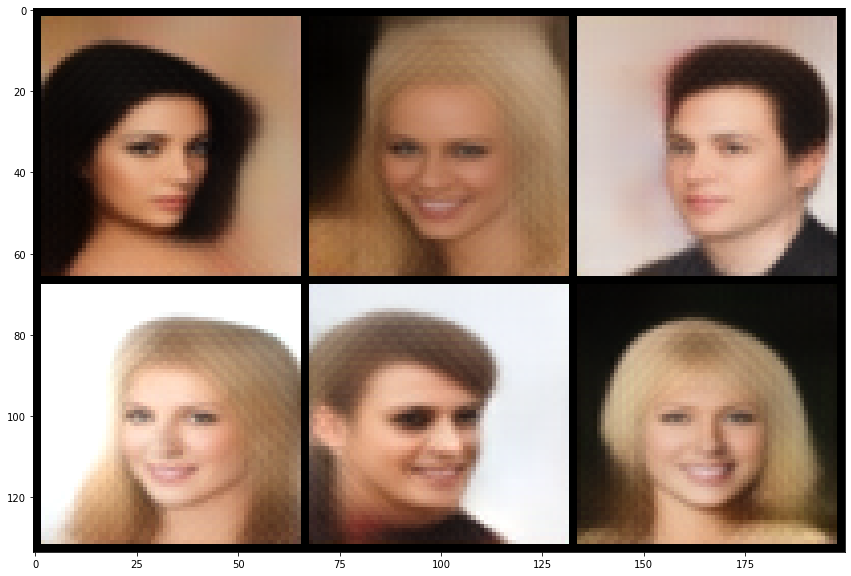

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


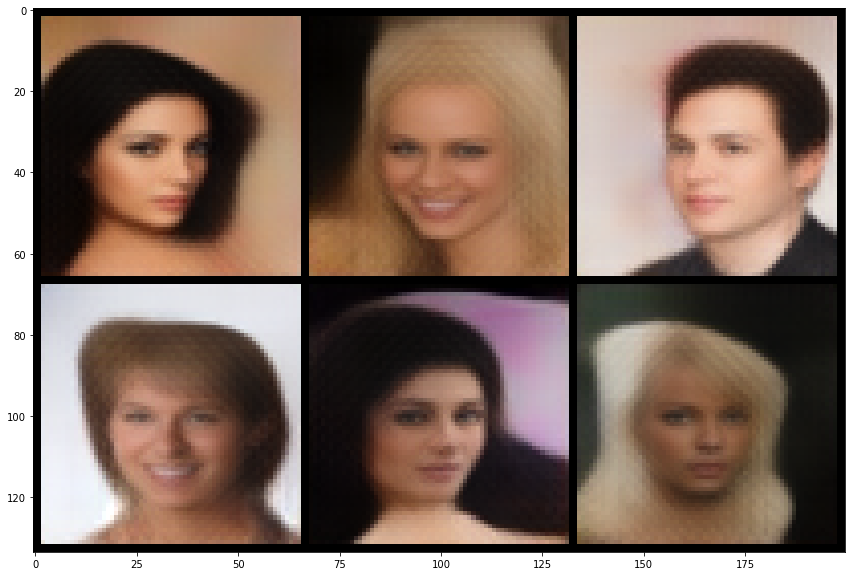

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


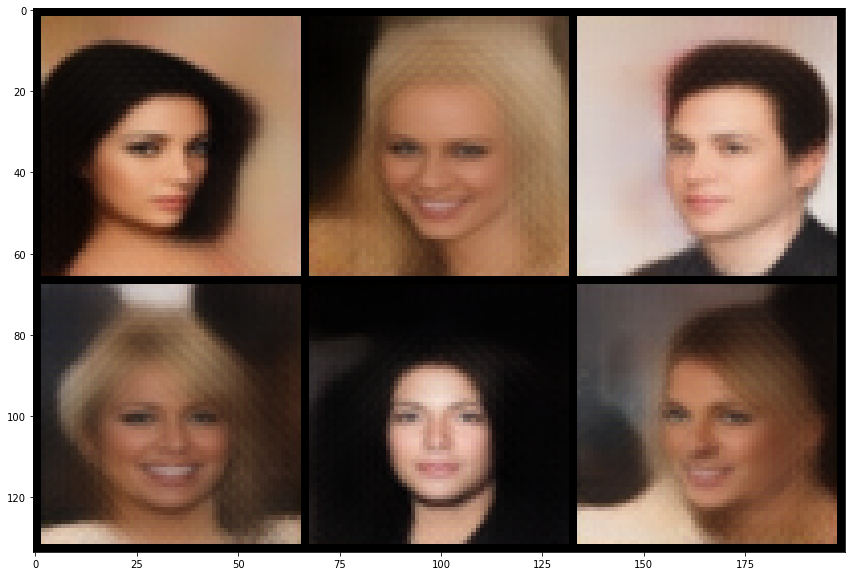

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


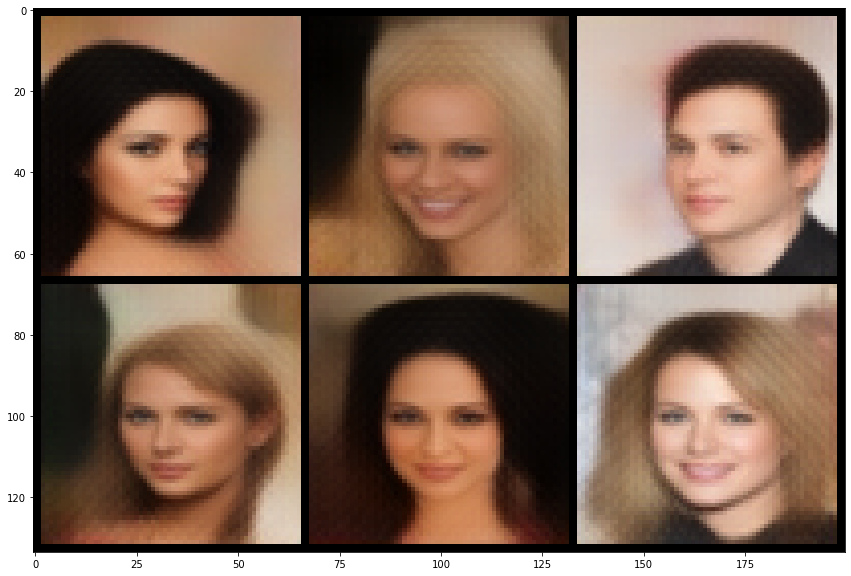

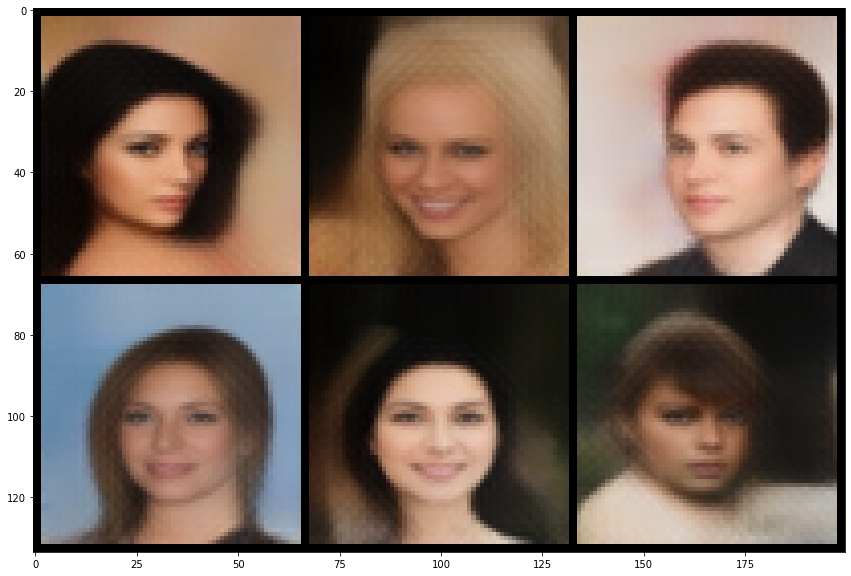

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


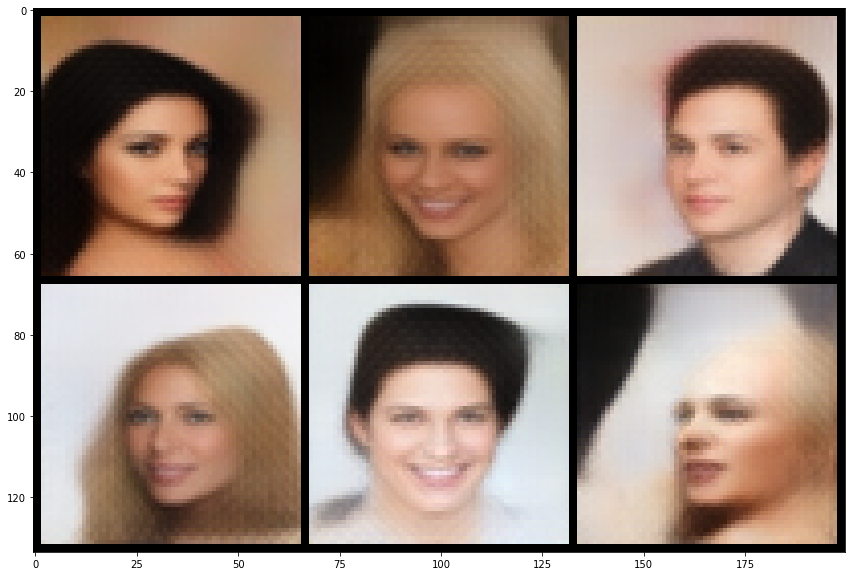

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


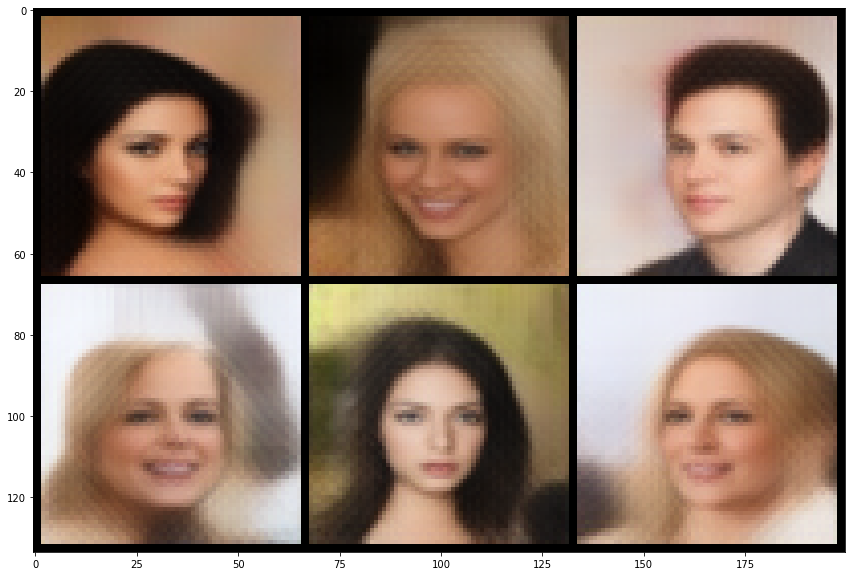

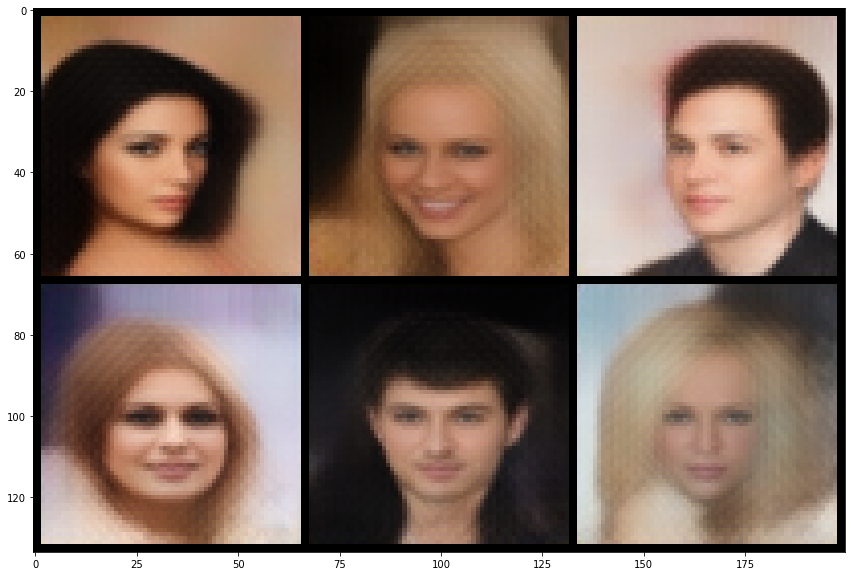

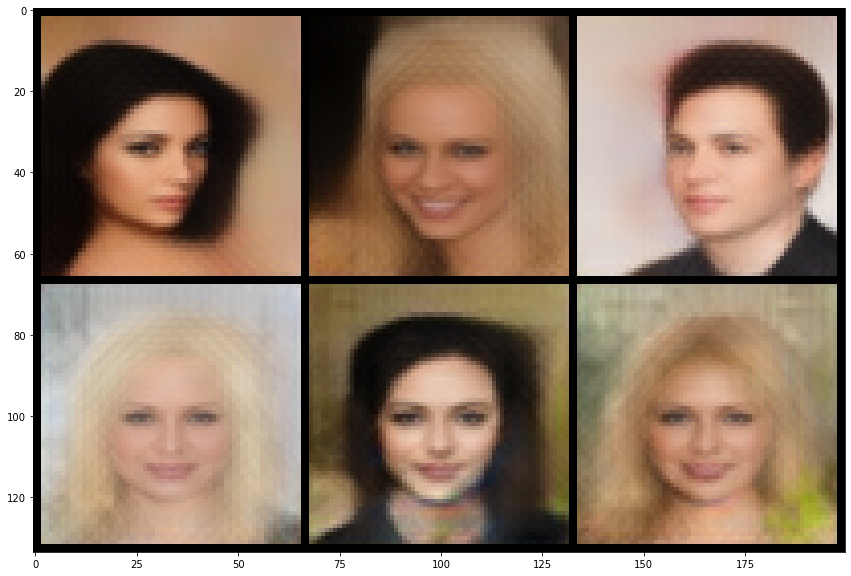

In [82]:
for drop in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    z_dim = 128
    cat_feature = 2
    joint_blocks = 4
    BN = False
    RATIO = 0.5

    Gen = LatentGenerator(z_dim, cat_feature, ratio=RATIO, joint_blocks=joint_blocks, bn = BN, drop=drop)
    Gen.load_state_dict(torch.load(f'LatentGenrator_Drop_HairColor{drop}.pth'))
    Gen = Gen.to(DEVICE)
    
    out = Gen(custom_batch, lab[:3])
    
    rec_original = autoencoder.decoder(custom_batch.reshape(3, 32, 2, 2)).cpu().detach()
    rec_generated = autoencoder.decoder(out.reshape(3, 32, 2, 2)).cpu().detach()

    plt.figure(figsize=(20, 10))
    plt.imshow(make_grid(torch.cat([rec_original, rec_generated], dim=0), nrow=3).numpy().transpose((1,2,0)))
    plt.show()

# `Male`

In [117]:
import pandas as pd
from PIL import Image

class CelebaDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 usecols = ['Male'],
                 transofrm = None,
                 attr_file='/root/data/CelebA/list_attr_celeba.txt',
                 dataset_location='/root/data/CelebA/img_align_celeba/'):
        """
        Avaliable attributes
        [0, '5_o_Clock_Shadow'], [1, 'Arched_Eyebrows'],  [2, 'Attractive'],  [3, 'Bags_Under_Eyes'],  [4, 'Bald'],
        [5, 'Bangs'], [6, 'Big_Lips'], [7, 'Big_Nose'], [8, 'Black_Hair'], [9, 'Blond_Hair'], [10, 'Blurry'],
        [11, 'Brown_Hair'], [12, 'Bushy_Eyebrows'], [13, 'Chubby'], [14, 'Double_Chin'], [15, 'Eyeglasses'],
        [16, 'Goatee'], [17, 'Gray_Hair'], [18, 'Heavy_Makeup'], [19, 'High_Cheekbones'], [20, 'Male'],
        [21, 'Mouth_Slightly_Open'], [22, 'Mustache'], [23, 'Narrow_Eyes'], [24, 'No_Beard'], [25, 'Oval_Face'],
        [26, 'Pale_Skin'], [27, 'Pointy_Nose'], [28, 'Receding_Hairline'], [29, 'Rosy_Cheeks'], [30, 'Sideburns'],
        [31, 'Smiling'], [32, 'Straight_Hair'], [33, 'Wavy_Hair'], [34, 'Wearing_Earrings'], [35, 'Wearing_Hat'],
        [36, 'Wearing_Lipstick'], [37, 'Wearing_Necklace'], [38, 'Wearing_Necktie'], [39, 'Young']
        """
        self.dataset_location = dataset_location
        self.usecols = usecols
        
        with open('/root/data/CelebA/list_attr_celeba.txt') as f:
            content = f.readlines()

        content = [[symb for symb in x.strip().split(' ') if symb != ''] for x in content[1:]] 
        content_df = pd.DataFrame(content[1:])
        content_df.columns = ['path'] + content[0]
        
        self.attributes = content_df[['path'] + usecols]
        self.attributes[usecols] = self.attributes[usecols].astype(float)
        
        self.transofrm = transofrm
        
    def __len__(self):
        return len(self.attributes)
    
    def __getitem__(self, idx):
        person = self.attributes.iloc[idx]
        
        attributes = np.maximum(person[self.usecols].values, 0)
        img = Image.open(os.path.join(self.dataset_location, person['path']))
        
        return (self.transofrm(img), torch.Tensor(attributes.tolist()))

In [119]:
train_dataset = CelebaDataset(usecols = ['Male'],
                              transofrm=torchvision.transforms.Compose([torchvision.transforms.Resize((64, 64)),
                                                                        torchvision.transforms.RandomHorizontalFlip(),
                                                                        torchvision.transforms.ToTensor()]))
train_loader = DataLoader(train_dataset, batch_size=128, num_workers=4, shuffle=True)

(array([ 7.,  9.,  7., 14., 18., 13., 13., 15.,  6., 10.,  6.,  2.,  2.,
         3.,  0.,  2.,  0.,  0.,  0.,  1.]),
 array([0.1718318 , 0.18404052, 0.19624922, 0.20845793, 0.22066665,
        0.23287536, 0.24508408, 0.25729278, 0.2695015 , 0.2817102 ,
        0.2939189 , 0.30612764, 0.31833634, 0.33054504, 0.34275377,
        0.35496247, 0.36717117, 0.3793799 , 0.3915886 , 0.40379733,
        0.41600603], dtype=float32),
 <a list of 20 Patch objects>)

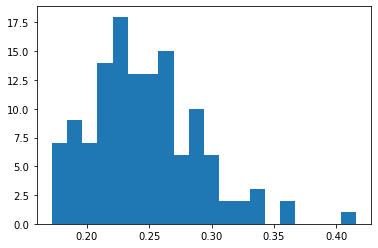

In [20]:
plt.hist(next(iter(train_loader))[0].std(dim=0), bins=20)

(array([ 2.,  3.,  4.,  4.,  3.,  5., 16., 21., 35., 11.,  5.,  5.,  4.,
         2.,  1.,  4.,  0.,  0.,  1.,  2.]),
 array([-0.9996158 , -0.8750701 , -0.7505244 , -0.6259787 , -0.501433  ,
        -0.37688732, -0.25234163, -0.12779593, -0.00325024,  0.12129545,
         0.24584115,  0.37038684,  0.49493253,  0.6194782 ,  0.7440239 ,
         0.8685696 ,  0.9931153 ,  1.117661  ,  1.2422067 ,  1.3667524 ,
         1.4912981 ], dtype=float32),
 <a list of 20 Patch objects>)

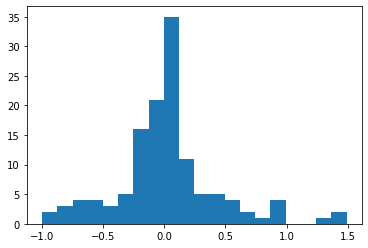

In [21]:
plt.hist(next(iter(train_loader))[0].mean(dim=0), bins=20)

In [120]:
iter_loader = iter(train_loader)

matrix = []

for batch, label in iter_loader:
    batch = batch.to(DEVICE)
    
    with torch.no_grad():
        emb = autoencoder.encoder(batch).reshape(batch.shape[0], -1).detach().cpu()
    
    matrix.append(torch.cat([emb, label], dim=-1))
    
# torch.save(torch.cat(matrix), 'MaleEmbedding_CelebA64.pth')

In [11]:
from time import time

class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, emb):
        self.embedding = emb
                
    def __len__(self):
        return len(self.embedding)
    
    def __getitem__(self, idx):
        obj = self.embedding[idx]
        one_hot_label = nn.functional.one_hot(torch.Tensor([obj[-1].item()]).long(), num_classes=2).flatten().float()
                
        return (obj[:-1], one_hot_label)

In [136]:
BS = 128

train_dataset = EmbeddingDataset(torch.load('MaleEmbedding_CelebA64.pth'))
train_loader = DataLoader(train_dataset, batch_size=BS, num_workers=4, shuffle=True)

In [55]:
for drop in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print(f'Current drop {drop}')
    
    
    z_dim = 128
    cat_feature = 2
    joint_blocks = 4

    BN = False
    RATIO = 0.5
#     drop = 0.5

    Gen = LatentGenerator(z_dim, cat_feature, ratio=RATIO, joint_blocks=joint_blocks, bn = BN, drop=drop).to(DEVICE)
    Disc = LatentDiscriminator(z_dim, cat_feature, ratio=RATIO, joint_blocks=joint_blocks, drop=drop).to(DEVICE)

    BCE = nn.BCEWithLogitsLoss()
    cycle = nn.L1Loss()

    lmbda = 10 # Cycle

    opt_Disc = torch.optim.Adam(Disc.parameters(), lr=1e-4, betas=(0, 0.99))
    opt_Gen = torch.optim.Adam(Gen.parameters(), lr=1e-4, betas=(0, 0.99))

    batches_tracked = 20_000
    loss_D, loss_G, loss_C = [], [], []

    std_m_, std_w_ = [], []

    autoencoder = autoencoder.to(DEVICE)
    autoencoder.eval();

    iter_loader = iter(train_loader)

    for iteration in tqdm(range(batches_tracked), total=batches_tracked):

        ####################################
        ############# Disc step ############
        ####################################

        t = time()

        batch_disc, label = next(iter_loader)
        batch_disc, label = batch_disc.to(DEVICE), label.to(DEVICE) 

        pred_real = Disc(batch_disc, label)
        loss_real = BCE(pred_real, torch.ones_like(pred_real).to(DEVICE))

        batch_gen, _ = next(iter_loader)
        batch_gen = batch_gen.to(DEVICE)

        gen_labels = sample_labels(BS, N_CLASSES=cat_feature).to(DEVICE)
        gen_fake = Gen(batch_gen, gen_labels)
        pred_fake = Disc(gen_fake, gen_labels)
        loss_fake = BCE(pred_fake, torch.zeros_like(pred_fake).to(DEVICE))

        loss_Disc = loss_real + loss_fake
        loss_D.append(loss_Disc.item())

    #     print('Disc forward:', time() - t)

        opt_Disc.zero_grad()
        loss_Disc.backward()
        opt_Disc.step()

    #     print('Disc backward:', time() - t)

        ####################################
        ############# Gen step #############
        ####################################

        batch_gen, gen_labels_orig = next(iter_loader)
        batch_gen, gen_labels_orig = batch_gen.to(DEVICE), gen_labels_orig.to(DEVICE)

        gen_labels = sample_labels(BS, N_CLASSES=cat_feature).to(DEVICE)
        gen_fake = Gen(batch_gen, gen_labels)
        pred_fake = Disc(gen_fake, gen_labels)

        loss_Gen = BCE(pred_fake, torch.ones_like(pred_fake).to(DEVICE))
        loss_cycle = cycle(batch_gen, Gen(gen_fake, gen_labels_orig))


        girl = gen_fake[gen_labels[:, 0] == 1]
        girl_std = -(girl - girl.mean(dim=0, keepdims=True)).pow(2).sum()

        men = gen_fake[gen_labels[:, 1] == 1]
        men_std = -(men - men.mean(dim=0, keepdims=True)).pow(2).sum()

        loss_G_total = loss_Gen + loss_cycle.mul(lmbda) + men_std.mul(lmbda) + girl_std.mul(lmbda)

        std_m_.append(girl_std.item())
        std_w_.append(men_std.item())

        loss_G.append(loss_Gen.item())
        loss_C.append(loss_cycle.item())

    #     print('Gen forward:', time() - t)

        opt_Gen.zero_grad()
        loss_Gen.backward()
        opt_Gen.step()

    #     print('Gen backward:', time() - t)


        if iteration %200 ==0:
            iter_loader = iter(train_loader)        


#         if iteration%1000 == 0:
#             show = 8

#             print('Desired labels:', gen_labels.argmax(dim=1)[:show].reshape(-1))        
#             rec_original = autoencoder.decoder(batch_gen.reshape(BS, 32, 2, 2)).cpu().detach()[:show]
#             rec_generated = autoencoder.decoder(gen_fake.reshape(BS, 32, 2, 2)).cpu().detach()[:show]

#             plt.figure(figsize=(20, 10))
#             plt.imshow(make_grid(torch.cat([rec_original, rec_generated], dim=0)).numpy().transpose((1,2,0)))
#             plt.show()
            
    torch.save(Gen.state_dict(), f'LatentGenrator_Drop{drop}.pth')

Current drop 0



Current drop 0.1



Current drop 0.2


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Current drop 0.3


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Current drop 0.4


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Current drop 0.6



Current drop 0.7



Current drop 0.8


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Current drop 0.9


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [56]:
print('Desired labels:', gen_labels.argmax(dim=1)[:show].reshape(-1))

Desired labels: tensor([0, 1, 0, 0, 1, 1, 0, 1], device='cuda:1')


0


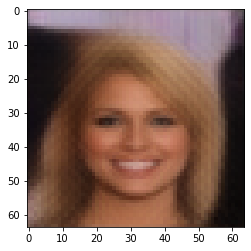

1


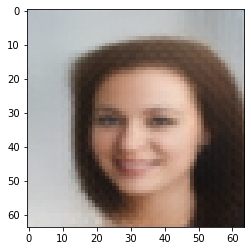

2


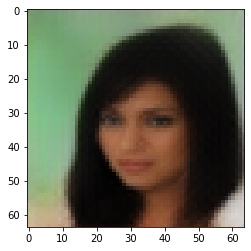

3


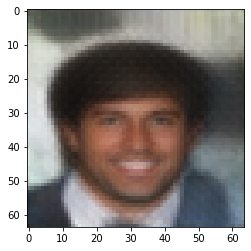

4


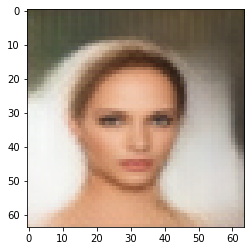

5


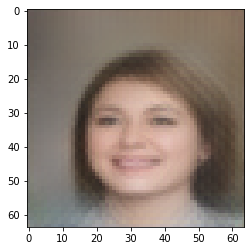

6


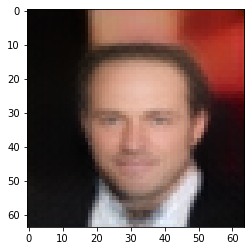

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7


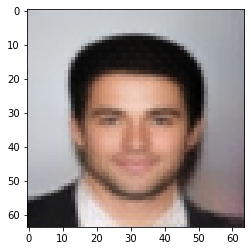

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8


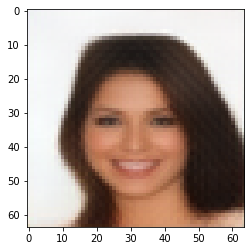

9


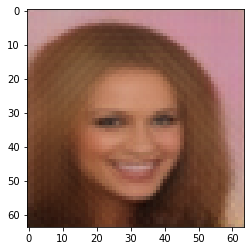

10


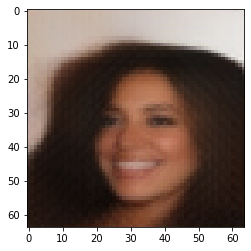

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11


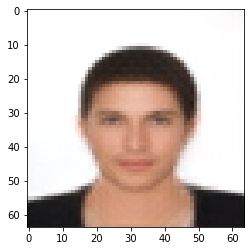

12


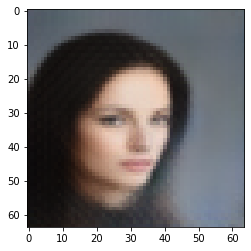

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13


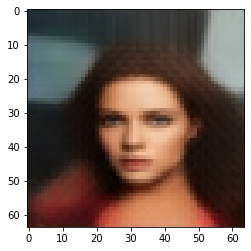

14


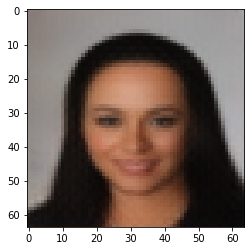

15


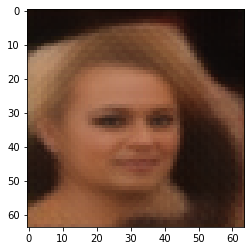

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16


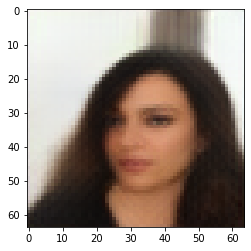

17


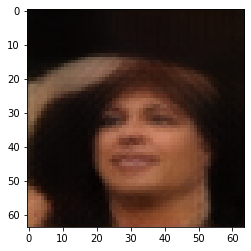

18


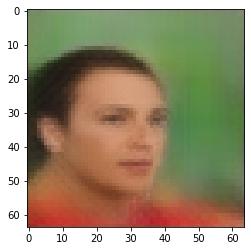

19


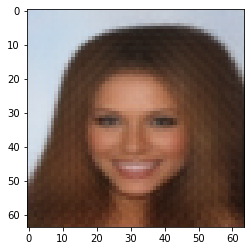

20


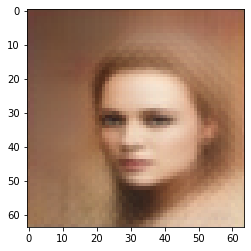

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21


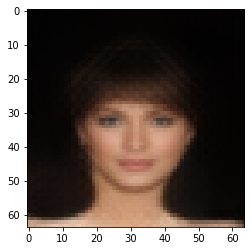

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22


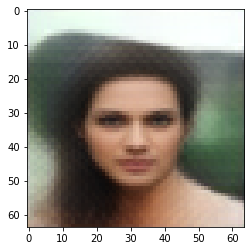

23


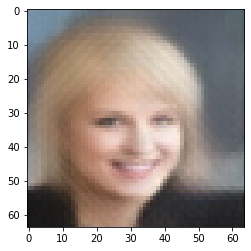

24


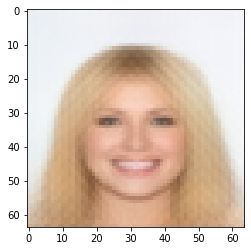

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25


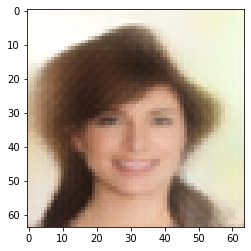

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26


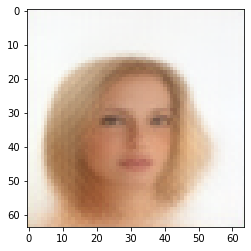

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27


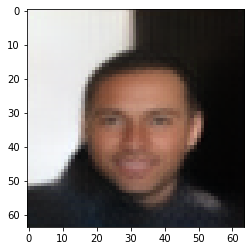

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28


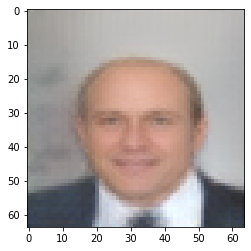

29


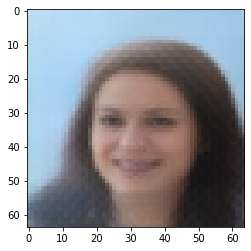

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30


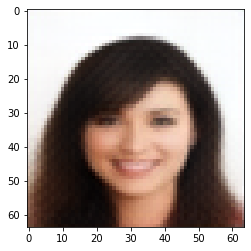

31


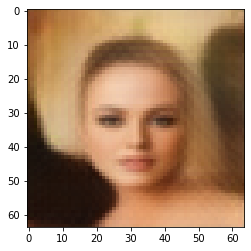

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32


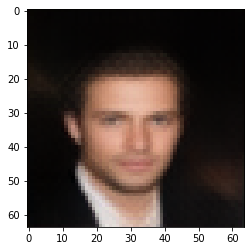

33


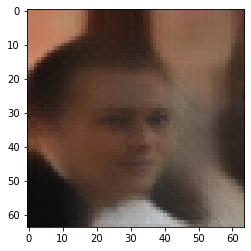

34


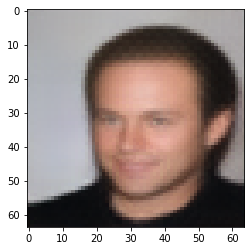

35


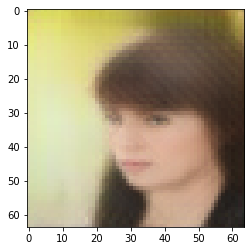

36


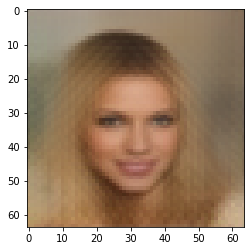

37


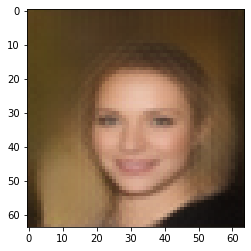

38


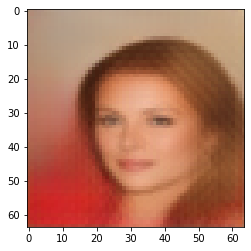

39


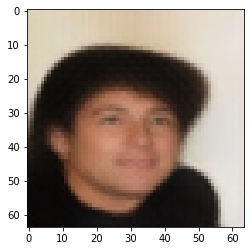

40


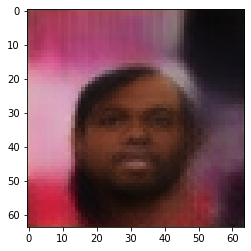

41


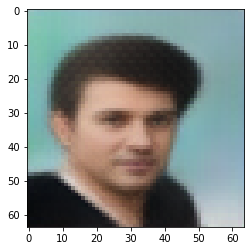

42


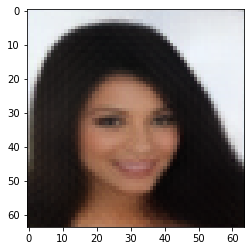

43


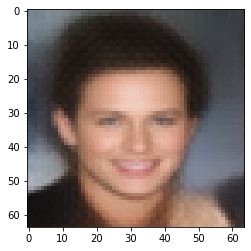

44


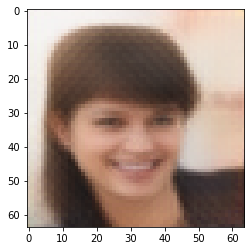

45


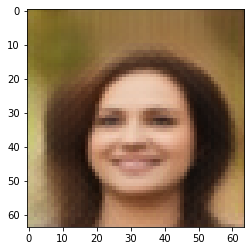

46


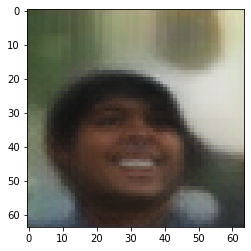

47


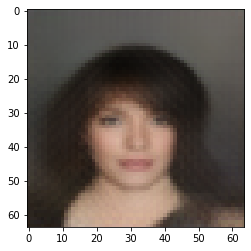

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


48


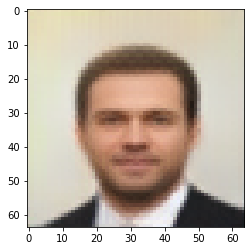

49


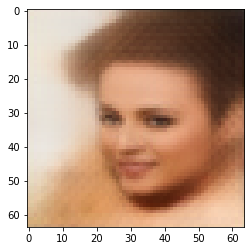

50


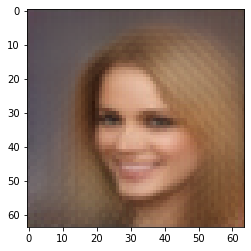

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


51


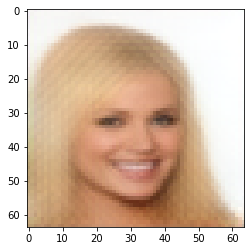

52


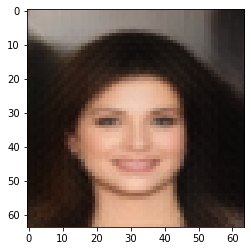

53


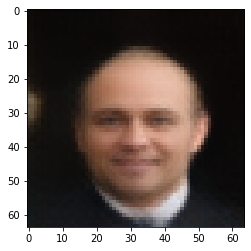

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


54


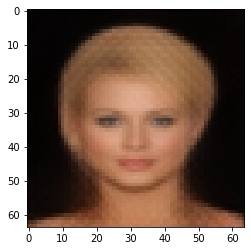

55


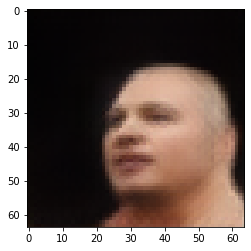

56


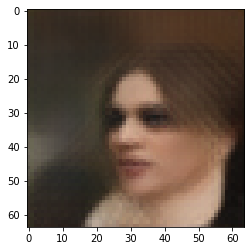

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


57


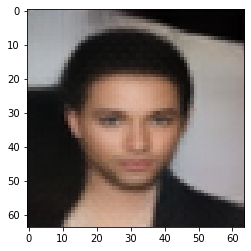

58


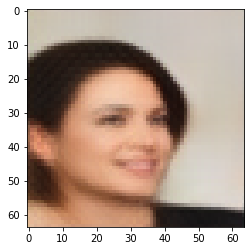

59


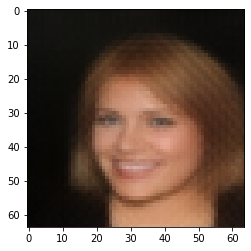

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


60


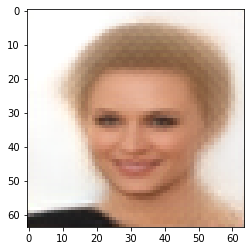

61


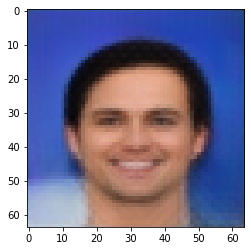

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


62


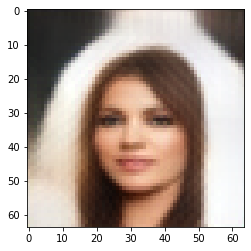

63


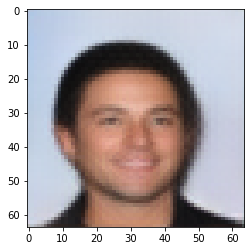

64


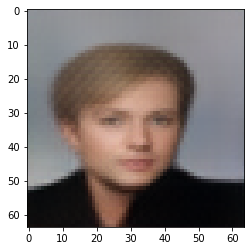

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65


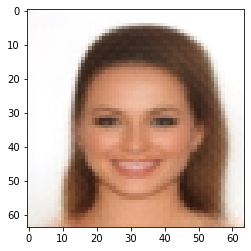

66


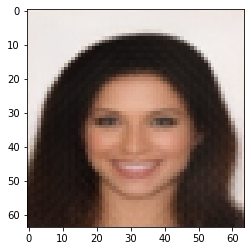

67


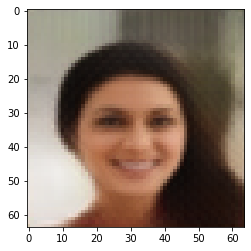

68


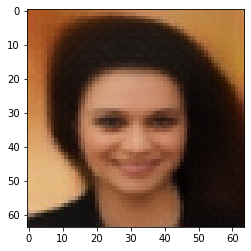

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


69


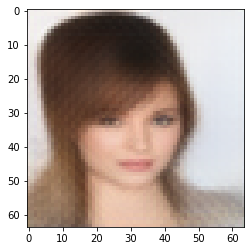

70


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


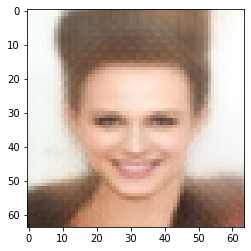

71


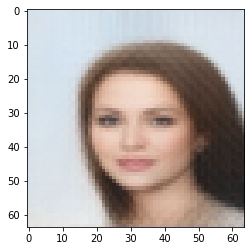

72


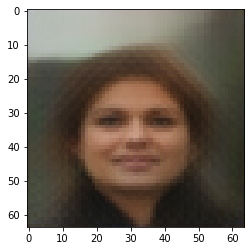

73


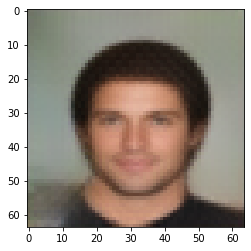

74


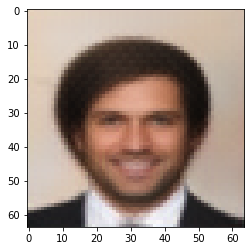

75


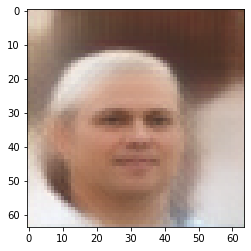

76


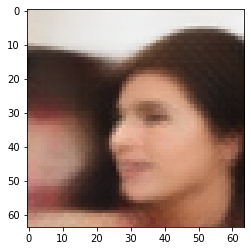

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


77


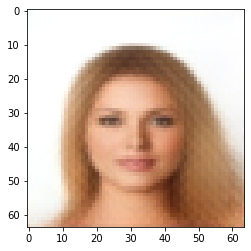

78


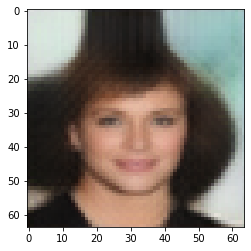

79


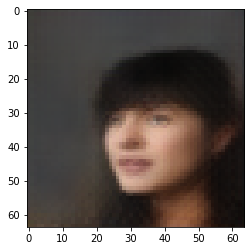

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


80


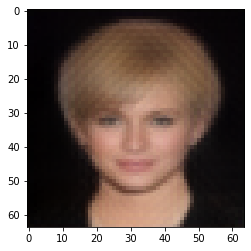

81


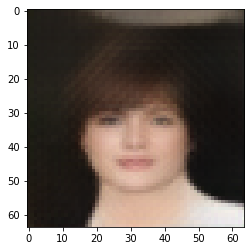

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


82


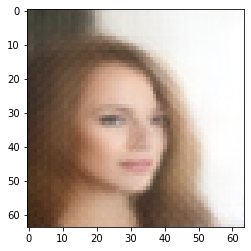

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


83


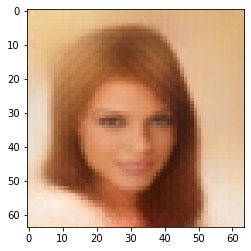

84


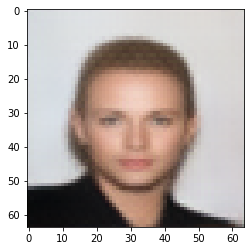

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


85


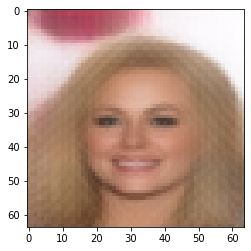

86


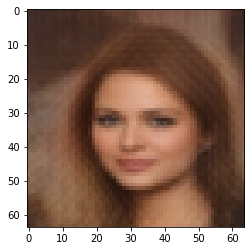

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


87


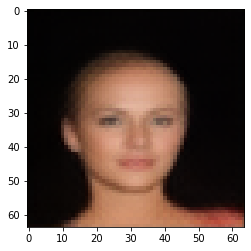

88


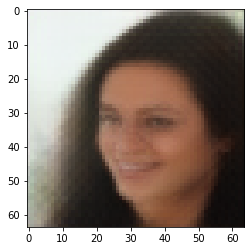

89


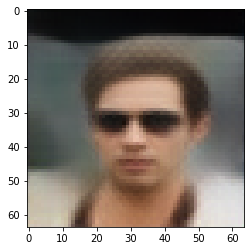

90


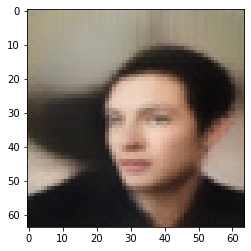

91


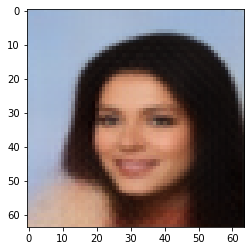

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


92


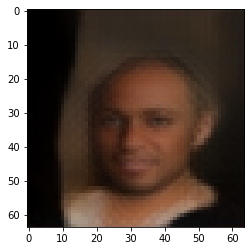

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


93


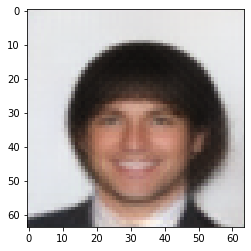

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


94


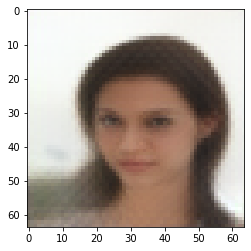

95


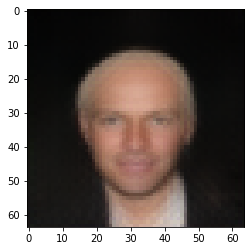

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


96


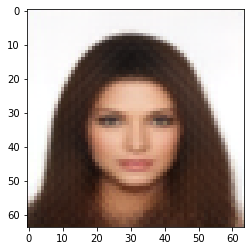

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


97


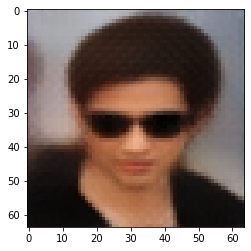

98


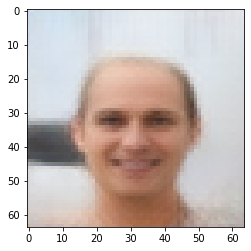

99


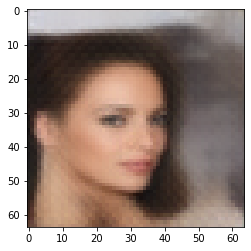

In [70]:
for i in range(100):
    print(i)
    code, _ = train_dataset[i]
    person = autoencoder.decoder(code.reshape(1, 32, 2, 2).to(DEVICE)).cpu().detach().numpy()[0]
    
    plt.imshow(person.transpose(1,2,0))
    plt.show()

In [78]:
p1, _ = train_dataset[10]
p1 = p1.reshape(1, 32, 2, 2).to(DEVICE)

p2, _ = train_dataset[82]
p2 = p2.reshape(1, 32, 2, 2).to(DEVICE)

codes = torch.cat([(1-i) * p2 + i * p1 for i in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


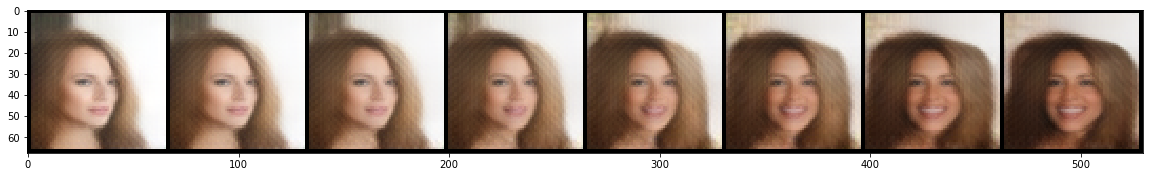

In [79]:
rec_generated = autoencoder.decoder(codes).cpu().detach()[:show]

plt.figure(figsize=(20, 10))
plt.imshow(make_grid(rec_generated).numpy().transpose((1,2,0)))
plt.show()

## Fine grained `visualization`

In [86]:
z_dim = 128
cat_feature = 2
joint_blocks = 4

BN = False
RATIO = 0.5

# batch_gen, gen_labels_orig = next(iter_loader)
# batch_gen, gen_labels_orig = batch_gen.to(DEVICE), gen_labels_orig.to(DEVICE)

for drop in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print(drop)
    Gen = LatentGenerator(z_dim, cat_feature, ratio=RATIO, joint_blocks=joint_blocks, bn = BN, drop=drop)
    Gen.load_state_dict(torch.load(f'LatentGenrator_Drop{drop}.pth'))
    Gen = Gen.to(DEVICE)
#     Gen.eval()
    
    gen_fake = Gen(batch_gen, gen_labels)
    
    gen_fake = Gen(codes.reshape(11, -1), gen_labels[:11])
    
    print('Desired labels:', gen_labels.argmax(dim=1)[:show].reshape(-1))        
    rec_original = autoencoder.decoder(codes.reshape(11, 32, 2, 2)).cpu().detach()[:show]
    rec_generated = autoencoder.decoder(gen_fake.reshape(11, 32, 2, 2)).cpu().detach()[:show]

    plt.figure(figsize=(20, 10))
    plt.imshow(make_grid(torch.cat([rec_original, rec_generated], dim=0)).numpy().transpose((1,2,0)))
    plt.show()

torch.Size([11, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Desired labels: tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:4')


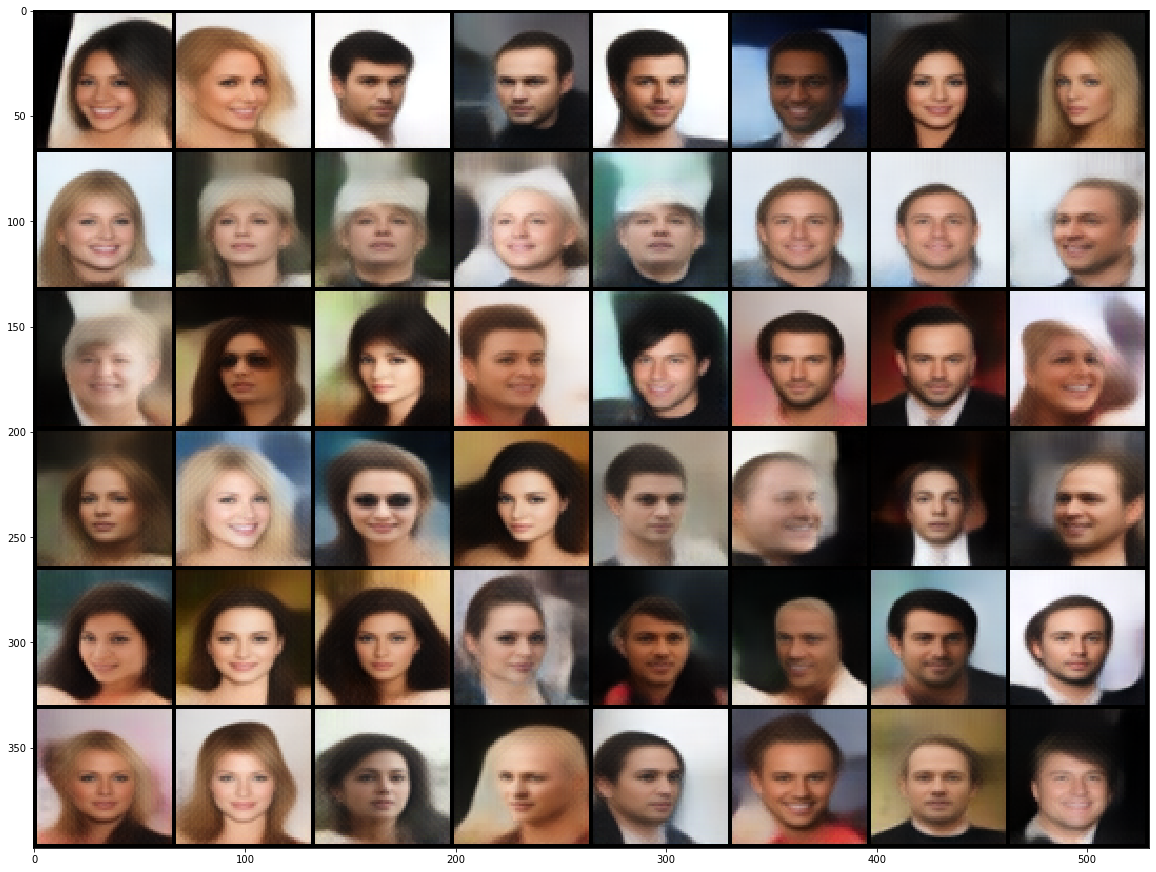

In [179]:
z_dim = 128
cat_feature = 2
joint_blocks = 4

BN = False
RATIO = 0.5

fakes = []
for drop in [0, 0.2, 0.4, 0.6, 0.8]:
    
    Gen = LatentGenerator(z_dim, cat_feature, ratio=RATIO, joint_blocks=joint_blocks, bn = BN, drop=drop)
    Gen.load_state_dict(torch.load(f'LatentGenrator_Drop{drop}.pth'))
    Gen = Gen.to(DEVICE)
    gen_fake = Gen(pool, gen_labels)
    
    fakes.append(gen_fake)
    
print('Desired labels:', gen_labels.argmax(dim=1)[:show].reshape(-1))        
rec_original = autoencoder.decoder(pool.reshape(8, 32, 2, 2)).cpu().detach()
fakes = autoencoder.decoder(torch.cat(fakes).reshape(len(fakes) * show, 32, 2, 2)).cpu().detach()

plt.figure(figsize=(20, 20))
plt.imshow(make_grid(torch.cat([rec_original, fakes], dim=0)).numpy().transpose((1,2,0)))
plt.show()

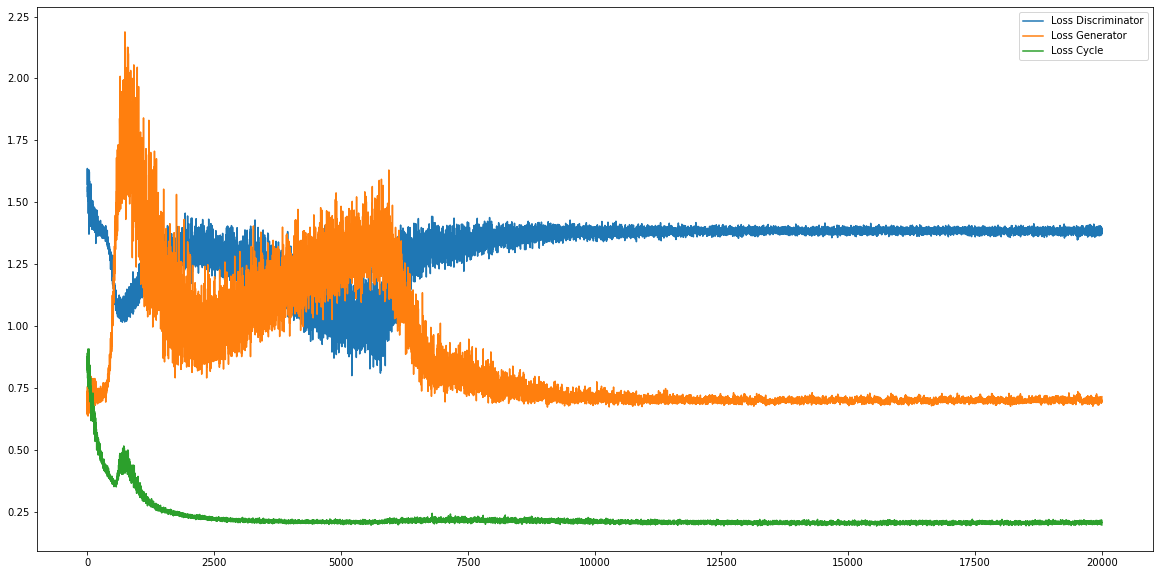

In [88]:
plt.figure(figsize=(20, 10))

plt.plot(loss_D, label='Loss Discriminator')
plt.plot(loss_G, label='Loss Generator')
plt.plot(loss_C, label='Loss Cycle')

# plt.semilogy(std_m, label='Std Male')
# plt.semilogy(std_w, label='Std Feale')

plt.legend()